# 대전시 교통사고 위험 지역 상위 100개소 만들기
## 라이브러리 불러오기

In [1]:
import folium
import json
import pandas as pd
import numpy as np
import geopandas as gpd
import fiona
import os
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = 'Nanum Gothic'
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False},
        style='darkgrid')


from shapely.geometry import Polygon, LineString, Point
from tqdm import tqdm

import warnings 
warnings.filterwarnings(action='ignore')

import cufflinks as cf 
cf.go_offline(connected=True)
cf.set_config_file(theme='polar')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

#최적화 solver
import time
from mip import Model, xsum, maximize, BINARY  

from patsy import dmatrices
import statsmodels.api as sm;

from statsmodels.stats.outliers_influence import variance_inflation_factor

/opt/app-root/lib/python3.6/site-packages/geopandas/_compat.py:91: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


Using Python-MIP package version 1.5.3


# 데이터 불러오기

In [1]:
data1 = pd.read_csv('1.대전광역시_교통사고내역(2017~2019).csv')
data2 = gpd.read_file('2.대전광역시_교통사고격자(2017~2019).geojson')
data3 = gpd.read_file('3.대전광역시_신호등(보행등).geojson')
data4 = gpd.read_file('4.대전광역시_신호등(차량등).geojson')
data5 = gpd.read_file('5.대전광역시_안전지대.geojson')
data6 = gpd.read_file('6.대전광역시_횡단보도.geojson')
data7 = gpd.read_file('7.대전광역시_도로속도표시.geojson')
data8 = gpd.read_file('8.대전광역시_정차금지지대.geojson')
data9 = gpd.read_file('9.대전광역시_교통안전표지.geojson')
data10 = gpd.read_file('10.대전광역시_교통CCTV.geojson')
data11 = pd.read_csv('11.대전광역시_동별_인구현황(2017~2019).csv')
data12 = gpd.read_file('12.대전광역시_인구정보(총인구).geojson')
data13 = gpd.read_file('13.대전광역시_인구정보(고령).geojson')
data14 = gpd.read_file('14.대전광역시_인구정보(생산가능).geojson')
data15 = gpd.read_file('15.대전광역시_인구정보(유소년).geojson')
data16 = pd.read_csv('16.대전광역시_기상데이터(2017~2019).csv')
data17 = gpd.read_file('17.대전광역시_교통링크(2018).geojson')
data18 = gpd.read_file('18.대전광역시_교통노드(2018).geojson')
data19 = gpd.read_file('19.대전광역시_상세도로망(2018).geojson')
data20 = pd.read_csv('20.대전광역시_평일_일별_시간대별_추정교통량(2018).csv')
data21 = pd.read_csv('21.대전광역시_평일_일별_혼잡빈도강도(2018).csv')
data22 = pd.read_csv('22.대전광역시_평일_일별_혼잡시간강도(2018).csv')
data23 = gpd.read_file('23.대전광역시_도로명주소(건물).geojson')
data24 = gpd.read_file('24.대전광역시_건물연면적_격자.geojson')
data25 = gpd.read_file('25.대전광역시_법정경계(시군구).geojson')
data26 = gpd.read_file('26.대전광역시_법정경계(읍면동).geojson')
data27 = gpd.read_file('27.대전광역시_행정경계(읍면동).geojson')
data28 = gpd.read_file('28.대전광역시_연속지적도.geojson')
data30 = gpd.read_file('30.대전광역시_차량등록현황_격자.geojson')
data31 = gpd.read_file('31.대전시_중앙분리대.geojson')

NameError: name 'pd' is not defined

# gid-geometry 관계데이터 추출

In [12]:
data_gid = data2[['gid', 'geometry']]
data_gid

,gid,geometry
0,다바866110,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ..."
1,다바823157,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ..."
2,다바928260,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ..."
3,다바931203,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ..."
4,다바836109,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ..."
...,...,...
54907,다바861065,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ..."
54908,다바912036,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ..."
54909,다바867189,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ..."
54910,다바851062,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ..."


## 필요한 함수 정의

In [5]:
# 데이터 카운트 함수
def road_count(data,facility): 
    gid_list = []
    for i in tqdm(range(data.shape[0])): 
        area = data['geometry'].iloc[i]
        cnt = facility['geometry'].within(area).sum()
        gid_list.append(cnt)
    return gid_list

# centroid 구현 함수
def centroid_road_count(data,facility): 
    gid_list = []
    for i in tqdm(range(data.shape[0])): 
        area = data['geometry'].iloc[i]
        cnt = facility['geometry'].centroid.within(area).sum()
        gid_list.append(cnt)
    return gid_list

# 그룹 1 : 1번 데이터(사고 기록)
## 데이터1 : 교통사고내역 상세
2017~2019년 기준 대전시 교통사고에 대한 상세정보 데이터

In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23652 entries, 0 to 23651
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   사고일        23652 non-null  object
 1   시군구        23652 non-null  object
 2   사고유형       23652 non-null  object
 3   법규위반       23652 non-null  object
 4   사고내용       23652 non-null  object
 5   사망자수       23652 non-null  int64 
 6   중상자수       23652 non-null  int64 
 7   경상자수       23652 non-null  int64 
 8   부상신고자수     23652 non-null  int64 
 9   가해운전자 차종   23652 non-null  object
 10  가해운전자 연령대  23652 non-null  object
 11  가해운전자 성별   23652 non-null  object
 12  피해운전자 차종   22981 non-null  object
 13  피해운전자 연령대  22981 non-null  object
 14  피해운전자 성별   22981 non-null  object
 15  gid        23652 non-null  object
dtypes: int64(4), object(12)
memory usage: 2.9+ MB


### 세부값들로 나누기

In [10]:
#시군구에서 구,동을 분리
data1['구'] = [x[1] for x in data1['시군구'].str.split(' ')]
data1['동'] = [x[2] for x in data1['시군구'].str.split(' ')]

#사고유형을 '-'를 기준으로 분리
data1['세부사고유형'] = [x[1] for x in data1['사고유형'].str.split('-')]
data1['사고유형'] = [x[0] for x in data1['사고유형'].str.split('-')]

#사고일에서 연도와 월을 분리
data1['사고월'] = [x[1] for x in data1['사고일'].str.split('-')]
data1['사고월']=data1['사고월'].astype(int)
data1['사고연도'] = [x[0] for x in data1['사고일'].str.split('-')]
data1['사고연도']=data1['사고연도'].astype(int)

#사고연도와 월을 합친 데이터 생성
data1['사고연월'] = str(data1['사고연도']) + '-' + str(data1['사고월'])
data1.head()

,사고일,시군구,사고유형,법규위반,사고내용,사망자수,중상자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 연령대,피해운전자 성별,gid,구,동,세부사고유형,사고월,사고연도,사고연월
0,2017-01-01,대전광역시 서구 용문동,차대차,안전운전불이행,중상사고,0,1,1,0,승용,50대,남,승용,60대,남,다바905151,서구,용문동,측면충돌,1,2017,0 2017\n1 2017\n2 2017\n3...
1,2017-01-01,대전광역시 서구 탄방동,차대차,안전운전불이행,경상사고,0,0,1,0,승용,50대,남,승용,30대,남,다바905166,서구,탄방동,추돌,1,2017,0 2017\n1 2017\n2 2017\n3...
2,2017-01-01,대전광역시 서구 둔산동,차대사람,안전운전불이행,중상사고,0,1,0,0,승용,30대,남,보행자,10대,여,다바888169,서구,둔산동,횡단중,1,2017,0 2017\n1 2017\n2 2017\n3...
3,2017-01-01,대전광역시 대덕구 오정동,차대차,안전운전불이행,경상사고,0,0,2,0,승용,50대,남,승합,40대,남,다바917174,대덕구,오정동,추돌,1,2017,0 2017\n1 2017\n2 2017\n3...
4,2017-01-01,대전광역시 유성구 노은동,차대사람,안전운전불이행,경상사고,0,0,1,0,승용,80대,남,보행자,10대미만,남,다바841191,유성구,노은동,횡단중,1,2017,0 2017\n1 2017\n2 2017\n3...


### 연령대 중 이상값을 제일 많이 나온 값으로 대체

In [11]:
data1['피해운전자 연령대']=data1['피해운전자 연령대'].replace('미분류','50대')
data1['가해운전자 연령대']=data1['가해운전자 연령대'].replace('미분류','30대')
data1['가해운전자 연령대']=data1['가해운전자 연령대'].replace('기타불명','30대')

### 피해 운전자 차종이 null인 값 삭제

In [12]:
drop_list = data1[data1['피해운전자 차종'].isnull()]
data1.drop(drop_list.index,axis=0,inplace=True)

## 데이터16: 기상데이터

In [13]:
data16.head()

,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),평균 상대습도(%),일 최심적설(cm),평균 지면온도(°C),안개 계속시간(hr)
0,2017-01-01,3.5,-1.3,10.7,NaN,3.1,180,0.7,81.5,NaN,3.3,NaN
1,2017-01-02,4.7,-0.4,10.8,NaN,5.2,180,1.5,83.0,NaN,3.4,NaN
2,2017-01-03,3.3,-1.5,9.2,NaN,3.9,180,1.4,77.1,NaN,3.0,NaN
3,2017-01-04,4.2,-0.2,10.7,NaN,2.4,320,1.0,70.5,NaN,3.1,NaN
4,2017-01-05,4.3,-0.7,9.3,NaN,5.6,110,1.9,71.3,NaN,2.9,NaN


In [14]:
#이상치 전처리
data16['일강수량(mm)'].replace('',0,inplace=True) 
data16['일 최심적설(cm)'].replace('',0,inplace=True)
data16['안개 계속시간(hr)'].replace('',0,inplace=True)
data16['평균 풍속(m/s)'].replace('',0,inplace=True)
data16.dropna(subset=['일강수량(mm)'],axis=0,inplace=True) 
data16

,일시,평균기온(°C),최저기온(°C),최고기온(°C),일강수량(mm),최대 풍속(m/s),최대 풍속 풍향(16방위),평균 풍속(m/s),평균 상대습도(%),일 최심적설(cm),평균 지면온도(°C),안개 계속시간(hr)
7,2017-01-08,8.8,5.0,14.8,0.0,3.5,140,1.3,64.8,NaN,8.2,NaN
8,2017-01-09,4.3,-0.9,8.0,0.0,4.4,320,2.3,62.3,NaN,4.8,NaN
10,2017-01-11,-3.1,-7.8,2.5,0.0,3.9,200,1.7,62.5,NaN,-2.1,NaN
11,2017-01-12,-0.3,-4.0,5.7,0.0,5.5,320,1.9,69.6,NaN,-0.8,NaN
12,2017-01-13,-3.7,-7.3,0.5,0.6,4.4,320,1.8,68.0,NaN,-2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2019-12-23,3.8,0.0,8.7,0.1,4.1,250,1.4,75.8,NaN,3.7,NaN
1089,2019-12-26,2.4,0.5,4.0,3.0,4.4,250,1.3,74.8,NaN,2.8,NaN
1092,2019-12-29,2.0,-2.3,6.3,7.0,4.0,70,1.1,76.6,NaN,1.6,NaN
1093,2019-12-30,4.2,-0.4,9.4,1.5,5.8,270,1.5,86.9,NaN,4.2,1.67


In [15]:
data16.rename(columns = {'일시' : '사고일'}, inplace = True)

In [16]:
#문자열로 되어있는 기상데이터를 모두 형변환
data16['평균기온(°C)'] = data16['평균기온(°C)'].astype(float)
data16['최저기온(°C)'] = data16['최저기온(°C)'].astype(float)
data16['최고기온(°C)'] = data16['최고기온(°C)'].astype(float)
data16['일강수량(mm)'] = data16['일강수량(mm)'].astype(float)
data16['최대 풍속(m/s)'] = data16['최대 풍속(m/s)'].astype(float)
data16['최대 풍속 풍향(16방위)'] = data16['최대 풍속 풍향(16방위)'].astype(float)
data16['평균 풍속(m/s)'] = data16['평균 풍속(m/s)'].astype(float)
data16['평균 상대습도(%)'] = data16['평균 상대습도(%)'].astype(float)
data16['일 최심적설(cm)'] = data16['일 최심적설(cm)'].astype(float)
data16['평균 지면온도(°C)'] = data16['평균 지면온도(°C)'].astype(float)
data16['안개 계속시간(hr)'] = data16['안개 계속시간(hr)'].astype(float)
data16.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 7 to 1094
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   사고일             418 non-null    object 
 1   평균기온(°C)        418 non-null    float64
 2   최저기온(°C)        418 non-null    float64
 3   최고기온(°C)        418 non-null    float64
 4   일강수량(mm)        418 non-null    float64
 5   최대 풍속(m/s)      418 non-null    float64
 6   최대 풍속 풍향(16방위)  418 non-null    float64
 7   평균 풍속(m/s)      418 non-null    float64
 8   평균 상대습도(%)      418 non-null    float64
 9   일 최심적설(cm)      38 non-null     float64
 10  평균 지면온도(°C)     418 non-null    float64
 11  안개 계속시간(hr)     31 non-null     float64
dtypes: float64(11), object(1)
memory usage: 42.5+ KB


### 1번파일과 16번 파일을 사고일을 기준으로 병합

In [17]:
data_weather = pd.merge(data1,data16,on='사고일',how='left')
data_weather = data_weather.fillna(0)
data_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22981 entries, 0 to 22980
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   사고일             22981 non-null  object 
 1   시군구             22981 non-null  object 
 2   사고유형            22981 non-null  object 
 3   법규위반            22981 non-null  object 
 4   사고내용            22981 non-null  object 
 5   사망자수            22981 non-null  int64  
 6   중상자수            22981 non-null  int64  
 7   경상자수            22981 non-null  int64  
 8   부상신고자수          22981 non-null  int64  
 9   가해운전자 차종        22981 non-null  object 
 10  가해운전자 연령대       22981 non-null  object 
 11  가해운전자 성별        22981 non-null  object 
 12  피해운전자 차종        22981 non-null  object 
 13  피해운전자 연령대       22981 non-null  object 
 14  피해운전자 성별        22981 non-null  object 
 15  gid             22981 non-null  object 
 16  구               22981 non-null  object 
 17  동               22981 non-null 

In [18]:
data_weather.to_csv('data_weather.csv',header=True,index=False)

# 그룹 2 : 2번 데이터(사고격자)
## 데이터2 : 교통사고 횟수
2017~2019년 기준 대전시 교통사고에 대한 100x100격자 사고건수 데이터

In [19]:
data2.head()

,gid,acci_cnt,geometry
0,다바866110,0,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ..."
1,다바823157,0,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ..."
2,다바928260,0,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ..."
3,다바931203,2,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ..."
4,다바836109,0,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ..."


### acci_cnt에 nearby 가중치 곱하기
- 근처에 있는 경우 acci_cnt가 중첩되는 부분이 있어, 이를 위해 가중치를 곱하기로 함

In [20]:
data2['center_x'] = data2['geometry'].centroid.x
data2['center_y'] = data2['geometry'].centroid.y
data2.head()

,gid,acci_cnt,geometry,center_x,center_y
0,다바866110,0,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",127.351318,36.296674
1,다바823157,0,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",127.303322,36.338977
2,다바928260,0,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",127.420231,36.431971
3,다바931203,2,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",127.423628,36.380586
4,다바836109,0,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",127.317908,36.295726


In [21]:
data2_300 = data2.copy().drop(['acci_cnt'], axis=1)
data2_300['geometry'] = data2['geometry'].centroid.buffer(0.0025)
data2_300.rename(columns={'gid': 'gid_buffer', 'center_x': 'center_x_buffer', 'center_y': 'center_y_buffer'}, inplace=True)

In [22]:
import math
def haversine(lon1, lat1, lon2, lat2):
    import math

    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
#     lon1, lat1 = coord1.x, coord1.y
#     lon2, lat2 = coord2.x, coord2.y

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers

    meters = round(meters, 3)
    km = round(km, 3)
    return meters

def relative_value(x, col):
    normalized = (x['inverse_d'] - x['inverse_d'].min())/(x['inverse_d'].max() - x['inverse_d'].min())
    weighted = normalized * x[col]
    return weighted.sum()

def value_weighted_by_idw(df, center_x1, center_y1, center_x2, center_y2, col, group_col):
    df.reset_index(drop=True, inplace=True)
    df['distance'] = df.apply(lambda x:haversine(x[center_x1], x[center_y1], x[center_x2], x[center_y2]), axis=1) 
    df['inverse_d'] = 1./df['distance']
    df.inverse_d.replace([np.inf], 1./50, inplace=True) #0나누는거 피하기위해 작은값주기
    
    val_list = df.groupby(group_col).apply(lambda x: relative_value(x, col)).tolist()
    return val_list

In [23]:
res_intersection = gpd.overlay(data2, data2_300, how='intersection')

In [24]:
res_intersection.reset_index(drop=True, inplace=True)
res_intersection['distance'] = res_intersection.apply(lambda x:haversine(x['center_x'], x['center_y'], x['center_x_buffer'], x['center_y_buffer']), axis=1) 
res_intersection['inverse_d'] = 1./res_intersection['distance']
res_intersection.inverse_d.replace([np.inf], 1./50, inplace=True)
res_intersection['weight'] = (res_intersection['inverse_d'] - res_intersection['inverse_d'].min())/(res_intersection['inverse_d'].max() - res_intersection['inverse_d'].min())

In [25]:
res = pd.DataFrame(res_intersection.groupby('gid_buffer').apply(lambda x: (x.weight * x.acci_cnt).sum()), columns=['acci_cnt_nearby']).reset_index()
data2_nearby = data2_300.merge(res, on='gid_buffer', how='inner')
data2_nearby.head()

,gid_buffer,geometry,center_x_buffer,center_y_buffer,acci_cnt_nearby
0,다바866110,"POLYGON ((127.35382 36.29667, 127.35381 36.296...",127.351318,36.296674,0.032538
1,다바823157,"POLYGON ((127.30582 36.33898, 127.30581 36.338...",127.303322,36.338977,1.567877
2,다바928260,"POLYGON ((127.42273 36.43197, 127.42272 36.431...",127.420231,36.431971,0.940304
3,다바931203,"POLYGON ((127.42613 36.38059, 127.42612 36.380...",127.423628,36.380586,3.979689
4,다바836109,"POLYGON ((127.32041 36.29573, 127.32040 36.295...",127.317908,36.295726,2.352736


In [26]:
data2_nearby.rename(columns={'gid_buffer':'gid'},inplace=True)
data2 = pd.merge(data2,data2_nearby[['gid','acci_cnt_nearby']], on= 'gid',how='left')

In [27]:
data2.drop(['acci_cnt','center_x','center_y'],axis=1,inplace=True)
data2.rename(columns={'acci_cnt_nearby':'acci_cnt'},inplace=True)
data2.head()

,gid,geometry,acci_cnt
0,다바866110,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0.032538
1,다바823157,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",1.567877
2,다바928260,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",0.940304
3,다바931203,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",3.979689
4,다바836109,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2.352736


In [28]:
data2.to_file('data2_new.geojson', driver= 'GeoJSON')

## 데이터3: 대전광역시 신호등(보행자) 

- loc_cd : 시설물의 위치코드
- sgnl_drn_cd : 신호등의 방향코드
- sgnl_knd_cd : 신호등의 종류코드

In [9]:
data2 = gpd.read_file('data2_new.geojson')

In [10]:
data3.head()

,gu,dong,jibun,loc_cd,sgnl_drn_cd,sgnl_knd_cd,geometry
0,서구,관저동,None,1,None,2,POINT (127.33462 36.29501)
1,유성구,노은동,None,1,None,2,POINT (127.32352 36.36703)
2,동구,판암동,None,1,None,2,POINT (127.46137 36.32029)
3,동구,판암동,None,1,None,2,POINT (127.45688 36.31913)
4,동구,판암동,None,1,None,2,POINT (127.45670 36.31918)


In [17]:
#data2의 각 격자내에 보행자 신호등이 몇개 있는지 계산
data2['SINHO_p'] = road_count(data_gid,data3)

100%|██████████| 54912/54912 [01:34<00:00, 579.87it/s]


In [18]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2


## 데이터4: 대전광역시 신호등(차량용) 
- loc_cd : 시설물의 위치코드
- sgnl_drn_cd  : 신호등의 방향코드
- sgnl_knd_cd : 신호등의 종류코드

In [19]:
data4.head()

,gu,dong,jibun,loc_cd,sgnl_drn_cd,sgnl_knd_cd,geometry
0,유성구,구암동,None,1,2,1,POINT (127.32922 36.34867)
1,유성구,구암동,None,1,2,1,POINT (127.32922 36.34862)
2,유성구,구암동,None,1,2,1,POINT (127.32939 36.34836)
3,동구,삼정동,11-17전,1,2,1,POINT (127.47768 36.33256)
4,유성구,구암동,None,1,2,1,POINT (127.32955 36.34862)


In [20]:
#data2의 각 격자내에 차량용 신호등이 몇개 있는지 계산
data2['SINHO_c'] = road_count(data_gid,data4)

100%|██████████| 54912/54912 [02:07<00:00, 430.51it/s]


In [21]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0


## 데이터5: 안전지대
- loc_cd : 시설물의 위치코드
- len : 안전지대의 길이

In [22]:
data5.head()

,gu,dong,jibun,loc_cd,len,geometry
0,대덕구,신탄진동,264-64도,1,37.0,"MULTIPOLYGON (((127.42963 36.44199, 127.42963 ..."
1,중구,중촌동,None,1,NaN,"MULTIPOLYGON (((127.40455 36.34746, 127.40450 ..."
2,유성구,봉산동,None,1,37.0,"MULTIPOLYGON (((127.38640 36.44254, 127.38633 ..."
3,None,None,None,1,50.0,"MULTIPOLYGON (((127.45363 36.27243, 127.45357 ..."
4,서구,갈마동,None,1,0.0,"MULTIPOLYGON (((127.36845 36.34528, 127.36845 ..."


In [23]:
#data2의 각 격자내에 안전지대가 몇개 있는지 계산
data2['SAFE_zone'] = centroid_road_count(data_gid,data5)

100%|██████████| 54912/54912 [48:52<00:00, 18.72it/s]  


## 데이터6: 횡단보도
- loc_cd : 시설물의 위치코드
- crsw_gbn_cd : 횡단보도 구분코드
- crsw_knd_cd : 횡단보도 종류코드
- hol_len : 횡단보도의 가로길이
- vel_len : 횡단보도의 세로길이

In [24]:
data6.head()

,gu,dong,jibun,loc_cd,crsw_gbn_cd,crsw_knd_cd,hol_len,vel_len,geometry
0,중구,문화동,None,1,1,1,6.0,26.0,"MULTIPOLYGON (((127.40803 36.31549, 127.40801 ..."
1,중구,유천동,None,1,1,1,4.0,11.0,"MULTIPOLYGON (((127.39799 36.31250, 127.39787 ..."
2,None,None,None,1,2,1,4.0,5.0,"MULTIPOLYGON (((127.43430 36.33902, 127.43423 ..."
3,None,None,None,1,2,1,6.0,7.0,"MULTIPOLYGON (((127.43651 36.33524, 127.43651 ..."
4,동구,삼성동,None,1,1,1,8.0,21.0,"MULTIPOLYGON (((127.42324 36.34282, 127.42307 ..."


In [25]:
#data2의 각 격자내에 횡단보도가 몇개 있는지 계산
data2['WALK_street']=centroid_road_count(data_gid,data6)

100%|██████████| 54912/54912 [1:20:52<00:00, 11.32it/s]


In [26]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2


## 데이터7: 도로속도표시

In [27]:
data7.head()

,gu,dong,jibun,char_ctt,geometry
0,서구,도안동,None,30,POINT (127.34400 36.32066)
1,유성구,원신흥동,None,30,POINT (127.34082 36.33462)
2,서구,둔산동,None,30,POINT (127.39448 36.35359)
3,대덕구,읍내동,None,50,POINT (127.38685 36.35398)
4,대덕구,오정동,None,30,POINT (127.41365 36.35662)


In [28]:
#data2의 각 격자내에 도로속도 표지판이 몇개 있는지 계산
data2['SPEED_street']=road_count(data_gid,data7)

100%|██████████| 54912/54912 [01:20<00:00, 685.81it/s]


## 데이터8: 정차금지지대

In [29]:
data8.head()

,gu,dong,jibun,loc_cd,len,geometry
0,대덕구,오정동,None,1,80.0,"MULTIPOLYGON (((127.41606 36.34810, 127.41609 ..."
1,대덕구,오정동,715도,1,0.0,"MULTIPOLYGON (((127.40957 36.35338, 127.40952 ..."
2,대덕구,오정동,726도,1,0.0,"MULTIPOLYGON (((127.41012 36.35291, 127.41010 ..."
3,대덕구,오정동,731도,1,0.0,"MULTIPOLYGON (((127.41558 36.34856, 127.41553 ..."
4,동구,삼성동,458도,1,0.0,"MULTIPOLYGON (((127.42394 36.34216, 127.42391 ..."


In [30]:
#data2의 각 격자내에 정차금지지대가 몇개 있는지 계산
data2['NO_jeongcha']=centroid_road_count(data_gid,data8)
data2

100%|██████████| 54912/54912 [34:26<00:00, 26.57it/s]


,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...
54907,다바861065,0.022481,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ...",0,0,0,0,0,0
54908,다바912036,0.000000,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ...",0,0,0,0,0,0
54909,다바867189,0.000000,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ...",0,0,0,0,0,0
54910,다바851062,0.000000,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ...",0,0,0,0,0,0


## 데이터9: 교통안전표시

In [31]:
data9.head()

,gu,dong,jibun,loc_cd,sign_met_cd,sign_knd_cd_f,sign_knd_cd_s,sign_knd_cd_t,sign_ctt_f,sign_ctt_s,sign_ctt_t,sign_atc_loc_cd,geometry
0,서구,관저동,None,1,3,2,None,None,None,None,None,None,POINT (127.32113 36.29368)
1,유성구,원내동,None,1,3,2,None,None,None,None,None,None,POINT (127.32049 36.29342)
2,서구,괴정동,None,1,3,3,None,None,None,None,None,None,POINT (127.38909 36.34050)
3,서구,관저동,None,1,3,1,4,None,None,None,None,None,POINT (127.31586 36.28560)
4,유성구,송정동,None,1,3,2,4,None,70,200m앞부터,None,None,POINT (127.25583 36.27995)


In [32]:
#data2의 각 격자내에 교통안전표지판이 몇개 있는지 계산
data2['STREET_safe']=road_count(data_gid,data9)

100%|██████████| 54912/54912 [05:09<00:00, 177.23it/s]


## 데이터10: CCTV

In [33]:
data10.head()

,gu,dong,jibun,geometry
0,대덕구,오정동,None,POINT (127.41523 36.35876)
1,대덕구,오정동,None,POINT (127.41524 36.35877)
2,서구,탄방동,None,POINT (127.40185 36.34503)
3,동구,가양동,None,POINT (127.44235 36.35098)
4,서구,용문동,None,POINT (127.39326 36.33812)


In [34]:
#data2의 각 격자내에 CCTV가 몇 개 있는지 계산
data2['CCTV']=road_count(data_gid,data10)
data2

100%|██████████| 54912/54912 [00:29<00:00, 1862.98it/s]


,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...
54907,다바861065,0.022481,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ...",0,0,0,0,0,0,0,0
54908,다바912036,0.000000,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ...",0,0,0,0,0,0,0,0
54909,다바867189,0.000000,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ...",0,0,0,0,0,0,0,0
54910,다바851062,0.000000,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ...",0,0,0,0,0,0,0,0


## 데이터12: 대전시 총인구

In [35]:
data12.head()

,gid,val,geometry
0,다마846996,NaN,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,NaN,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,NaN,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,NaN,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,NaN,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."


In [36]:
#val에 있는 nan값 전처리
np.nan_to_num(data12['val'], copy = False)

#data2와 합친뒤 총인구(TOTAL_p)로 열 이름 변경
data2 = pd.merge(data2, data12[['gid','val']], on='gid')
data2.rename(columns = {"val": "TOTAL_p"}, inplace = True)

In [37]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13.0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267.0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78.0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0.0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396.0


## 데이터13: 대전시 고령자

In [38]:
data13.head()

,gid,val,geometry
0,다마846996,NaN,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,NaN,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,NaN,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,NaN,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,NaN,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."


In [39]:
#val에 있는 nan값 전처리
np.nan_to_num(data13['val'], copy = False)

#data2와 합친뒤 고령자(OLD_p)로 열 이름 변경
data2 = pd.merge(data2, data13[['gid','val']], on='gid')
data2.rename(columns = {"val": "OLD_p"}, inplace = True)

In [40]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13.0,0.0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267.0,25.0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78.0,0.0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0.0,0.0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396.0,28.0


## 데이터14: 대전시 생산가능

In [41]:
data14.head()

,gid,val,geometry
0,다마846996,NaN,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,NaN,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,NaN,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,NaN,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,NaN,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."


In [42]:
#val에 있는 nan값 전처리
np.nan_to_num(data14['val'], copy = False)

#data2와 합친뒤 생산가능인구(WORK_p)로 열 이름 변경
data2 = pd.merge(data2, data14[['gid','val']], on='gid')
data2.rename(columns = {"val": "WORK_p"}, inplace = True)

In [43]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13.0,0.0,10.0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267.0,25.0,198.0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78.0,0.0,65.0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0.0,0.0,0.0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396.0,28.0,339.0


## 데이터15: 대전시 유소년

In [44]:
data15.head()

,gid,val,geometry
0,다마846996,NaN,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,NaN,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,NaN,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,NaN,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,NaN,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."


In [45]:
#val에 있는 nan값 전처리
np.nan_to_num(data15['val'], copy = False)

#data2와 합친뒤 유소년인구(YOUNG_p)로 열 이름 변경
data2 = pd.merge(data2, data15[['gid','val']], on='gid')
data2.rename(columns = {"val": "YOUNG_p"}, inplace = True)

In [46]:
#인구데이터를 모두 int로 형변환
data2 = data2.astype({'TOTAL_p': int, 'OLD_p':int,'WORK_p':int,'YOUNG_p': int})
data2

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13,0,10,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267,25,198,44
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78,0,65,8
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0,0,0,0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396,28,339,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54907,다바861065,0.022481,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ...",0,0,0,0,0,0,0,0,0,0,0,0
54908,다바912036,0.000000,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ...",0,0,0,0,0,0,0,0,0,0,0,0
54909,다바867189,0.000000,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ...",0,0,0,0,0,0,0,0,0,0,0,0
54910,다바851062,0.000000,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ...",0,0,0,0,0,0,0,0,0,0,0,0


## 데이터18: 교통노드

In [47]:
data18.head()

,NODE_ID,NODE_TYPE,NODE_NAME,TURN_P,REMARK,geometry
0,1860000303,101,두마IC,0,None,MULTIPOINT (127.26479 36.27539)
1,1850000703,101,서대전IC,0,None,MULTIPOINT (127.31957 36.28751)
2,1860000304,101,삿갓집입구,0,None,MULTIPOINT (127.28988 36.26759)
3,1860000602,101,방동대교앞,0,None,MULTIPOINT (127.30941 36.28333)
4,1860000501,101,방동사거리,0,None,MULTIPOINT (127.30034 36.28004)


In [48]:
data2['NODE_cnt']=road_count(data_gid,data18)

100%|██████████| 54912/54912 [00:51<00:00, 1059.25it/s]


In [49]:
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13,0,10,0,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267,25,198,44,1
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78,0,65,8,2
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0,0,0,0,0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396,28,339,29,0


## 데이터24: 건물연면적_격자

In [50]:
data24.head()

,gid,val,geometry
0,다바866110,146.59,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ..."
1,다바823157,5944.98,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ..."
2,다바928260,1487.49,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ..."
3,다바931203,1291.19,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ..."
4,다바836109,12875.52,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ..."


In [51]:
data2 = pd.merge(data2, data24[['gid','val']], on='gid')
data2.rename(columns = {"val": "BUILDING_size"}, inplace = True)
np.nan_to_num(data2['BUILDING_size'], copy = False)
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt,BUILDING_size
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13,0,10,0,0,146.59
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267,25,198,44,1,5944.98
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78,0,65,8,2,1487.49
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0,0,0,0,0,1291.19
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396,28,339,29,0,12875.52


## 데이터30: 차량등록현황 격자

In [52]:
data30.head()

,gid,cars_cnt,geometry
0,다마846996,0,"MULTIPOLYGON (((127.32871 36.19342, 127.32871 ..."
1,다마847995,0,"MULTIPOLYGON (((127.32983 36.19252, 127.32982 ..."
2,다마847996,0,"MULTIPOLYGON (((127.32982 36.19342, 127.32982 ..."
3,다마847997,0,"MULTIPOLYGON (((127.32982 36.19432, 127.32982 ..."
4,다마847998,0,"MULTIPOLYGON (((127.32982 36.19522, 127.32982 ..."


In [53]:
data2 = pd.merge(data2, data30[['gid','cars_cnt']], on='gid')
data2.rename(columns = {"cars_cnt": "REGISTER_car"}, inplace = True)
data2.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt,BUILDING_size,REGISTER_car
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13,0,10,0,0,146.59,4
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267,25,198,44,1,5944.98,0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78,0,65,8,2,1487.49,40
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0,0,0,0,0,1291.19,409
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396,28,339,29,0,12875.52,0


## 데이터31: 중앙분리대

In [54]:
data31.head()

,byc_len,byc_wid,std_hit,geometry
0,9.03,0.1,1.0,"MULTIPOLYGON (((127.35022 36.33998, 127.35022 ..."
1,18.13,0.1,1.0,"MULTIPOLYGON (((127.34994 36.31754, 127.34994 ..."
2,33.84,0.1,1.0,"MULTIPOLYGON (((127.34853 36.31767, 127.34853 ..."
3,33.84,0.1,1.0,"MULTIPOLYGON (((127.34931 36.31778, 127.34931 ..."
4,33.85,0.1,1.0,"MULTIPOLYGON (((127.35010 36.31790, 127.35010 ..."


In [57]:
data2['Center_div']=centroid_road_count(data_gid,data31)
data2.head()

100%|██████████| 54912/54912 [35:10<00:00, 26.02it/s]


,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div
0,다바866110,0.032538,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0,0,0,0,0,0,0,0,13,0,10,0,0,146.59,4,0
1,다바823157,1.567877,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",3,4,2,3,0,0,14,0,267,25,198,44,1,5944.98,0,0
2,다바928260,0.940304,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",6,5,0,4,3,0,14,0,78,0,65,8,2,1487.49,40,0
3,다바931203,3.979689,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",1,3,1,1,2,0,5,0,0,0,0,0,0,1291.19,409,0
4,다바836109,2.352736,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2,0,0,2,0,0,6,0,396,28,339,29,0,12875.52,0,0


In [58]:
data2.to_csv('data_cnt_final.csv',header=True,index=False)

# 그룹 3 : road 데이터
## 데이터19: 상세도로망

In [5]:
data19.head()

,link_id,max_speed,road_name,road_no,road_rank,link_type,road_type,facil_name,up_lanes,dw_lanes,oneway,length,width,car_lane,num_cross,barrier,up_its_id,dw_its_id,geometry
0,553700043,50,호남고속도로지선,251,108,8,0,None,1,0,1,0.645,1,0,0,0,1850000700,0,"MULTILINESTRING ((127.27979 36.24906, 127.2799..."
1,553700273,30,장안로,0,104,32768,0,None,1,1,0,0.673,2,0,0,0,1850015800,1850015700,"MULTILINESTRING ((127.34376 36.24681, 127.3436..."
2,553700308,30,장안로,0,104,32768,0,None,1,1,0,1.095,2,0,0,0,1850015300,1850015400,"MULTILINESTRING ((127.34510 36.24442, 127.3451..."
3,553700340,0,벌곡로330번길,0,104,34816,0,None,1,1,0,0.065,1,0,0,0,0,0,"MULTILINESTRING ((127.29585 36.22254, 127.2958..."
4,553700456,30,장안로,0,104,32768,0,None,1,1,0,0.276,2,0,0,0,1850015700,1850015800,"MULTILINESTRING ((127.34376 36.24681, 127.3450..."


In [6]:
data19 = data19[['link_id', 'geometry']]
data19['link_id'] = data19['link_id'].astype(int)
data19

,link_id,geometry
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799..."
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436..."
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451..."
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958..."
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450..."
...,...,...
10841,565110608,"MULTILINESTRING ((127.52063 36.35414, 127.5205..."
10842,565110629,"MULTILINESTRING ((127.50770 36.33864, 127.5048..."
10843,565110680,"MULTILINESTRING ((127.51468 36.35256, 127.5149..."
10844,565110681,"MULTILINESTRING ((127.51787 36.35341, 127.5149..."


## 데이터20: 평일 일별 시간대별 교통량

In [7]:
data20.head()

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
0,55470005601,101,0.809,통영대전고속도로,대전광역시,동구,산내동,0,164,114,13,37
1,55470005701,101,0.819,통영대전고속도로,대전광역시,동구,산내동,0,170,126,7,37
2,55470070801,101,0.878,통영대전고속도로,대전광역시,동구,산내동,0,165,115,13,37
3,55470071001,101,0.883,통영대전고속도로,대전광역시,동구,산내동,0,172,128,7,37
4,55470071201,101,1.622,통영대전고속도로,대전광역시,동구,산내동,0,173,128,7,38


In [8]:
## LinkID를 9자리로 만들어 주기 -- 뒤에 두자리는 상행, 하행을 뜻함
id11 = list(data20['상세도로망_LinkID'])
id9 = [num//100 for num in id11]
data20['상세도로망_LinkID']=id9

In [9]:
# 전일 전체,승용차, 버스, 화물차 추정교통량
data20_day = data20[data20['시간적범위'] == 'fulltime']
data20_day

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,시간적범위,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
447519,564219331,101,0.121,경부고속도로,대전광역시,대덕구,덕암동,fulltime,48551,32056,1551,14943
447520,564217636,101,0.244,경부고속도로,대전광역시,대덕구,덕암동,fulltime,53311,35491,1742,16079
447521,564201125,101,0.354,경부고속도로,대전광역시,대덕구,덕암동,fulltime,50328,33943,1695,14690
447522,564202143,101,0.518,경부고속도로,대전광역시,대덕구,덕암동,fulltime,52747,34830,1708,16209
447523,564219329,101,0.533,경부고속도로,대전광역시,대덕구,덕암동,fulltime,53349,35516,1743,16089
...,...,...,...,...,...,...,...,...,...,...,...,...
479345,564104189,103,0.040,대전로,대전광역시,동구,삼성동,fulltime,16822,13873,254,2695
479346,564104189,103,0.040,대전로,대전광역시,동구,삼성동,fulltime,17001,14002,260,2739
479347,564104298,103,0.043,대전로,대전광역시,동구,삼성동,fulltime,11587,9551,176,1860
479348,564104298,103,0.043,대전로,대전광역시,동구,삼성동,fulltime,14213,11845,207,2161


In [10]:
result20_day = data20_day[['상세도로망_LinkID','전체_추정교통량','승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량']].groupby(['상세도로망_LinkID']).mean()
result20_day.reset_index(inplace=True)
result20_day.head()

,상세도로망_LinkID,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량
0,553700043,695.0,458.0,19.0,218.0
1,553700273,3871.5,3449.0,22.0,401.0
2,553700308,3240.0,2926.5,15.5,297.5
3,553700340,609.5,593.0,0.5,16.0
4,553700456,3140.5,2833.0,15.0,292.5


In [11]:
#시간대별(0-5, 6-11, 12-17, 18-23) 전체 추정교통량
d = data20
d = d.astype({'시간적범위':'string'})

d_0_5 = d[(d['시간적범위']=='0')|(d['시간적범위']=='1')|(d['시간적범위']=='2')|(d['시간적범위']=='3')|(d['시간적범위']=='4')|(d['시간적범위']=='5')][['상세도로망_LinkID','전체_추정교통량']].groupby('상세도로망_LinkID').mean()
d_0_5 = d_0_5.reset_index()

d_6_11 = d[(d['시간적범위']=='6')|(d['시간적범위']=='7')|(d['시간적범위']=='8')|(d['시간적범위']=='9')|(d['시간적범위']=='10')|(d['시간적범위']=='11')][['상세도로망_LinkID','전체_추정교통량']].groupby('상세도로망_LinkID').mean()
d_6_11 = d_6_11.reset_index()

d_12_17 = d[(d['시간적범위']=='12')|(d['시간적범위']=='13')|(d['시간적범위']=='14')|(d['시간적범위']=='15')|(d['시간적범위']=='16')|(d['시간적범위']=='17')][['상세도로망_LinkID','전체_추정교통량']].groupby('상세도로망_LinkID').mean()
d_12_17 = d_12_17.reset_index()

d_18_23 = d[(d['시간적범위']=='18')|(d['시간적범위']=='19')|(d['시간적범위']=='20')|(d['시간적범위']=='21')|(d['시간적범위']=='22')|(d['시간적범위']=='23')][['상세도로망_LinkID','전체_추정교통량']].groupby('상세도로망_LinkID').mean()
d_18_23 = d_18_23.reset_index()

In [12]:
result20_time = pd.concat([d_0_5, d_6_11, d_12_17, d_18_23], axis=1)
result20_time = result20_time.iloc[:, [0,1,3,5,7]]
result20_time.columns = ['상세도로망_LinkID', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23']

In [13]:
result20_time.head()

,상세도로망_LinkID,traf_0_5,traf_6_11,traf_12_17,traf_18_23
0,553700043,7.333333,36.166667,46.333333,26.000000
1,553700273,23.750000,224.583333,245.416667,151.500000
2,553700308,20.750000,187.500000,203.250000,128.666667
3,553700340,3.083333,36.333333,38.833333,23.500000
4,553700456,20.083333,181.083333,197.500000,124.583333


In [14]:
data_road = pd.merge(data19, result20_day, left_on = 'link_id', right_on = '상세도로망_LinkID', how = 'left')
data_road = data_road.drop(['상세도로망_LinkID'],axis=1)
data_road = pd.merge(data_road, result20_time, left_on = 'link_id', right_on = '상세도로망_LinkID', how = 'left')
data_road = data_road.drop(['상세도로망_LinkID'],axis=1)

# 교통량 전 시간대 평균, 표준편차
data_road['traf_mean'] = data_road.iloc[:,6:10].mean(axis=1)
data_road['traf_var'] = data_road.iloc[:, 6:10].std(axis=1)

In [15]:
data_road.head()

,link_id,geometry,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,traf_0_5,traf_6_11,traf_12_17,traf_18_23,traf_mean,traf_var
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799...",695.0,458.0,19.0,218.0,7.333333,36.166667,46.333333,26.000000,28.958333,16.635735
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",3871.5,3449.0,22.0,401.0,23.750000,224.583333,245.416667,151.500000,161.312500,100.160597
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",3240.0,2926.5,15.5,297.5,20.750000,187.500000,203.250000,128.666667,135.041667,82.679057
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",609.5,593.0,0.5,16.0,3.083333,36.333333,38.833333,23.500000,25.437500,16.346561
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",3140.5,2833.0,15.0,292.5,20.083333,181.083333,197.500000,124.583333,130.812500,80.154289


# 데이터21: 평일 일별 혼잡빈도강도

In [16]:
data21.head()

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,혼잡빈도강도
0,56421933101,101,0.121,경부고속도로,대전광역시,대덕구,덕암동,28.24
1,56421763601,101,0.244,경부고속도로,대전광역시,대덕구,덕암동,32.06
2,56420112501,101,0.354,경부고속도로,대전광역시,대덕구,덕암동,28.35
3,56420214301,101,0.518,경부고속도로,대전광역시,대덕구,덕암동,33.16
4,56421932901,101,0.533,경부고속도로,대전광역시,대덕구,덕암동,29.66


In [17]:
id11 = list(data21['상세도로망_LinkID'])
id9 = [num//100 for num in id11]
data21['상세도로망_LinkID']=id9

In [18]:
result21 = data21[['상세도로망_LinkID','혼잡빈도강도']].groupby(['상세도로망_LinkID']).mean()
result21.reset_index(inplace=True)

In [19]:
data_road = pd.merge(data_road, result21, left_on = 'link_id', right_on = '상세도로망_LinkID', how = 'left')
data_road = data_road.drop(['상세도로망_LinkID'],axis=1)

#결측값 0으로 채우기
data_road= data_road[data_road['혼잡빈도강도'] != "Na"]
data_road = data_road.fillna(0)

data_road.head()

,link_id,geometry,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,traf_0_5,traf_6_11,traf_12_17,traf_18_23,traf_mean,traf_var,혼잡빈도강도
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799...",695.0,458.0,19.0,218.0,7.333333,36.166667,46.333333,26.000000,28.958333,16.635735,0.000
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",3871.5,3449.0,22.0,401.0,23.750000,224.583333,245.416667,151.500000,161.312500,100.160597,5.340
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",3240.0,2926.5,15.5,297.5,20.750000,187.500000,203.250000,128.666667,135.041667,82.679057,1.705
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",609.5,593.0,0.5,16.0,3.083333,36.333333,38.833333,23.500000,25.437500,16.346561,88.160
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",3140.5,2833.0,15.0,292.5,20.083333,181.083333,197.500000,124.583333,130.812500,80.154289,0.425


# 데이터22: 평일 일별 혼잡시간강도

In [20]:
data22.head()

,상세도로망_LinkID,도로등급,링크길이,도로명,시도명,시군구명,읍면동명,혼잡시간강도
0,56421933101,101,0.121,경부고속도로,대전광역시,대덕구,덕암동,35.50
1,56421763601,101,0.244,경부고속도로,대전광역시,대덕구,덕암동,47.61
2,56420112501,101,0.354,경부고속도로,대전광역시,대덕구,덕암동,34.51
3,56420214301,101,0.518,경부고속도로,대전광역시,대덕구,덕암동,41.23
4,56421932901,101,0.533,경부고속도로,대전광역시,대덕구,덕암동,36.67


In [21]:
## LinkID를 9자리로 만들어 주기 -- 뒤에 두자리는 상행, 하행을 뜻함
id11 = list(data22['상세도로망_LinkID'])
id9 = [num//100 for num in id11]
data22['상세도로망_LinkID']=id9

In [22]:
result22= data22[['상세도로망_LinkID','혼잡시간강도']].groupby(['상세도로망_LinkID']).mean()
result22.reset_index(inplace=True)

In [23]:
data_road = pd.merge(data_road, result22, left_on = 'link_id', right_on = '상세도로망_LinkID', how = 'left')
data_road = data_road.drop(['상세도로망_LinkID'],axis=1)

In [24]:
data_road.head()

,link_id,geometry,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,traf_0_5,traf_6_11,traf_12_17,traf_18_23,traf_mean,traf_var,혼잡빈도강도,혼잡시간강도
0,553700043,"MULTILINESTRING ((127.27979 36.24906, 127.2799...",695.0,458.0,19.0,218.0,7.333333,36.166667,46.333333,26.000000,28.958333,16.635735,0.000,NaN
1,553700273,"MULTILINESTRING ((127.34376 36.24681, 127.3436...",3871.5,3449.0,22.0,401.0,23.750000,224.583333,245.416667,151.500000,161.312500,100.160597,5.340,15.250
2,553700308,"MULTILINESTRING ((127.34510 36.24442, 127.3451...",3240.0,2926.5,15.5,297.5,20.750000,187.500000,203.250000,128.666667,135.041667,82.679057,1.705,4.540
3,553700340,"MULTILINESTRING ((127.29585 36.22254, 127.2958...",609.5,593.0,0.5,16.0,3.083333,36.333333,38.833333,23.500000,25.437500,16.346561,88.160,92.470
4,553700456,"MULTILINESTRING ((127.34376 36.24681, 127.3450...",3140.5,2833.0,15.0,292.5,20.083333,181.083333,197.500000,124.583333,130.812500,80.154289,0.425,1.575


In [25]:
data_road.columns

Index(['link_id', 'geometry', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도'], dtype='object')

In [26]:
data_road.to_file('data_road.geojson', driver= 'GeoJSON')

## 교통량 정리

In [27]:
road_list = []
for i in tqdm(range(data_gid.shape[0])):
    gid = data_gid['geometry'].iloc[i]
    tf = data_road['geometry'].intersects(gid)
    g = data_road[['전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량','traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean','traf_var', '혼잡빈도강도', '혼잡시간강도']].loc[tf]
    g1 = g.mean()
    road_list.append(g1)

100%|██████████| 54912/54912 [03:36<00:00, 253.59it/s]


In [28]:
road = pd.DataFrame(road_list)
road_gid = pd.DataFrame()
road_gid['gid'] = data_gid['gid']

road_gid = pd.concat([road_gid, road],axis=1)
road_gid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   gid         54912 non-null  object 
 1   전체_추정교통량    12411 non-null  float64
 2   승용차_추정교통량   12411 non-null  float64
 3   버스_추정교통량    12411 non-null  float64
 4   화물차_추정교통량   12411 non-null  float64
 5   traf_0_5    12411 non-null  float64
 6   traf_6_11   12411 non-null  float64
 7   traf_12_17  12411 non-null  float64
 8   traf_18_23  12411 non-null  float64
 9   traf_mean   12411 non-null  float64
 10  traf_var    12411 non-null  float64
 11  혼잡빈도강도      12411 non-null  float64
 12  혼잡시간강도      12161 non-null  float64
dtypes: float64(12), object(1)
memory usage: 5.4+ MB


In [29]:
road_gid.to_csv('road_gid.csv',header=True,index=False)

In [30]:
# road_gid.to_file('road_gid.geojson', driver= 'GeoJSON')

# 도로가 존재하는 격자만 추출

In [31]:
#지적도 타입 분리하기
data28['type']=data28['JIBUN'].str[-1]
data28.head()

,PNU,JIBUN,geometry,type
0,3011011800102720006,272-6대,"MULTIPOLYGON (((127.42879 36.33470, 127.42866 ...",대
1,3011011800102820035,282-35대,"MULTIPOLYGON (((127.42585 36.33465, 127.42570 ...",대
2,3011011800102820016,282-16대,"MULTIPOLYGON (((127.42674 36.33470, 127.42678 ...",대
3,3011011800102730001,273-1대,"MULTIPOLYGON (((127.42810 36.33471, 127.42821 ...",대
4,3011011800102750001,275-1대,"MULTIPOLYGON (((127.42724 36.33464, 127.42708 ...",대


In [32]:
#타입 특성 파악하기
data28['type']=data28['type'].astype("string")
data28['type'].unique()

<StringArray>
['대', '도', '창', '답', '전', '임', '학', '천', '잡', '차', '장', '종', '제', '공', '구', '철', '유', '과', '목', '묘', '주', '체', '수', '가', '원', '사', '양', '염', '1', '0', '9', '광']
Length: 32, dtype: string

In [33]:
#지적도에서 도로(도)만 뽑기
road=data28[data28['type']=='도']

In [34]:
road = road.reset_index().drop(['index'],axis=1)

In [35]:
road_list = []
for i in tqdm(range(data_gid.shape[0])):
    gid = data_gid['geometry'].iloc[i]
    a = road['geometry'].intersects(gid).sum()
    road_list.append(a)

100%|██████████| 54912/54912 [07:54<00:00, 115.63it/s]


In [36]:
road_l = list(road_list)
gid = list(data_gid['gid'])
road_join = pd.DataFrame()
road_join['gid'] = gid
road_join['road'] = road_l
road_join

,gid,road
0,다바866110,4
1,다바823157,5
2,다바928260,18
3,다바931203,18
4,다바836109,13
...,...,...
54907,다바861065,0
54908,다바912036,0
54909,다바867189,0
54910,다바851062,0


In [37]:
#도로 존재 여부 (y/n) 변수 
road_join.loc[road_join['road']>0, ['road']] = 1
road_join.head()

,gid,road
0,다바866110,1
1,다바823157,1
2,다바928260,1
3,다바931203,1
4,다바836109,1


# 데이터 전부 수합 및 파일로 저장

In [44]:
data_all = pd.read_csv('data_cnt_final.csv')
final = pd.merge(data_all, road_gid, on = 'gid', how = 'outer')
final.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,traf_0_5,traf_6_11,traf_12_17,traf_18_23,traf_mean,traf_var,혼잡빈도강도,혼잡시간강도
0,다바866110,0.032538,MULTIPOLYGON (((127.3507618774412 36.296222652...,0,0,0,0,0,0,0,0,13,0,10,0,0,146.59,4,0,8283.000,6998.500,91.500,1192.500,55.416667,490.416667,518.333333,316.416667,345.145833,212.811247,0.3500,2.74000
1,다바823157,1.567877,MULTIPOLYGON (((127.3027655376963 36.338525724...,3,4,2,3,0,0,14,0,267,25,198,44,1,5944.98,0,0,1181.625,1021.875,10.125,149.875,4.750000,68.354167,79.812500,44.104167,49.255208,33.195902,21.1575,38.47125
2,다바928260,0.940304,MULTIPOLYGON (((127.419673399625 36.4315196906...,6,5,0,4,3,0,14,0,78,0,65,8,2,1487.49,40,0,3783.750,3263.500,32.500,488.125,32.145833,217.875000,250.916667,129.541667,157.619792,98.097637,48.0125,70.80250
3,다바931203,3.979689,MULTIPOLYGON (((127.4230710131166 36.380134552...,1,3,1,1,2,0,5,0,0,0,0,0,0,1291.19,409,0,11596.000,9698.000,132.000,1765.500,52.750000,670.083333,790.750000,419.333333,483.229167,326.025834,97.3600,98.50000
4,다바836109,2.352736,MULTIPOLYGON (((127.3173525982284 36.295274737...,2,0,0,2,0,0,6,0,396,28,339,29,0,12875.52,0,0,678.875,610.000,5.500,63.500,4.875000,39.479167,42.458333,26.166667,28.244792,17.137756,48.4675,87.26000


In [45]:
# 결측값 0으로 채우기 
final= final[final['gid'] != "Na"]
data_final = final.fillna(0)

In [46]:
# csv 파일 저장 
data_final.to_csv('final_data.csv', encoding='utf-8-sig',index=False)

In [47]:
# 격자 데이터 저장 
data_gid.to_file('gid_data.geojson', driver= 'GeoJSON')

In [48]:
data_final.head()

,gid,acci_cnt,geometry,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,OLD_p,WORK_p,YOUNG_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,승용차_추정교통량,버스_추정교통량,화물차_추정교통량,traf_0_5,traf_6_11,traf_12_17,traf_18_23,traf_mean,traf_var,혼잡빈도강도,혼잡시간강도
0,다바866110,0.032538,MULTIPOLYGON (((127.3507618774412 36.296222652...,0,0,0,0,0,0,0,0,13,0,10,0,0,146.59,4,0,8283.000,6998.500,91.500,1192.500,55.416667,490.416667,518.333333,316.416667,345.145833,212.811247,0.3500,2.74000
1,다바823157,1.567877,MULTIPOLYGON (((127.3027655376963 36.338525724...,3,4,2,3,0,0,14,0,267,25,198,44,1,5944.98,0,0,1181.625,1021.875,10.125,149.875,4.750000,68.354167,79.812500,44.104167,49.255208,33.195902,21.1575,38.47125
2,다바928260,0.940304,MULTIPOLYGON (((127.419673399625 36.4315196906...,6,5,0,4,3,0,14,0,78,0,65,8,2,1487.49,40,0,3783.750,3263.500,32.500,488.125,32.145833,217.875000,250.916667,129.541667,157.619792,98.097637,48.0125,70.80250
3,다바931203,3.979689,MULTIPOLYGON (((127.4230710131166 36.380134552...,1,3,1,1,2,0,5,0,0,0,0,0,0,1291.19,409,0,11596.000,9698.000,132.000,1765.500,52.750000,670.083333,790.750000,419.333333,483.229167,326.025834,97.3600,98.50000
4,다바836109,2.352736,MULTIPOLYGON (((127.3173525982284 36.295274737...,2,0,0,2,0,0,6,0,396,28,339,29,0,12875.52,0,0,678.875,610.000,5.500,63.500,4.875000,39.479167,42.458333,26.166667,28.244792,17.137756,48.4675,87.26000


In [62]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gid            54912 non-null  object 
 1   acci_cnt       54912 non-null  float64
 2   geometry       54912 non-null  object 
 3   SINHO_p        54912 non-null  int64  
 4   SINHO_c        54912 non-null  int64  
 5   SAFE_zone      54912 non-null  int64  
 6   WALK_street    54912 non-null  int64  
 7   SPEED_street   54912 non-null  int64  
 8   NO_jeongcha    54912 non-null  int64  
 9   STREET_safe    54912 non-null  int64  
 10  CCTV           54912 non-null  int64  
 11  TOTAL_p        54912 non-null  int64  
 12  OLD_p          54912 non-null  int64  
 13  WORK_p         54912 non-null  int64  
 14  YOUNG_p        54912 non-null  int64  
 15  NODE_cnt       54912 non-null  int64  
 16  BUILDING_size  54912 non-null  float64
 17  REGISTER_car   54912 non-null  int64  
 18  Center

In [64]:
data_gid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       54912 non-null  object  
 1   geometry  54912 non-null  geometry
dtypes: geometry(1), object(1)
memory usage: 858.1+ KB


In [65]:
# geojson 파일로 저장
data_final.drop('geometry',axis=1,inplace=True)
data_final = pd.merge(data_gid,data_final,on='gid')
data_final = gpd.GeoDataFrame(data_final, geometry='geometry')
data_final.head()
data_final.to_file('final_dataset.geojson', driver="GeoJSON",index=False)

# 상관계수 플랏과 다중공선성 진단

데이터 변수가 많아 차원의 저주,다중공선성 문제 우려, 변수들 상관관계 고려하여 변수들 전처리

## Data_final : Correlation plot

In [45]:
data_final = pd.read_csv('final_data.csv')

In [46]:
data_final.columns

Index(['gid', 'acci_cnt', 'geometry', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'OLD_p', 'WORK_p', 'YOUNG_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도'], dtype='object')

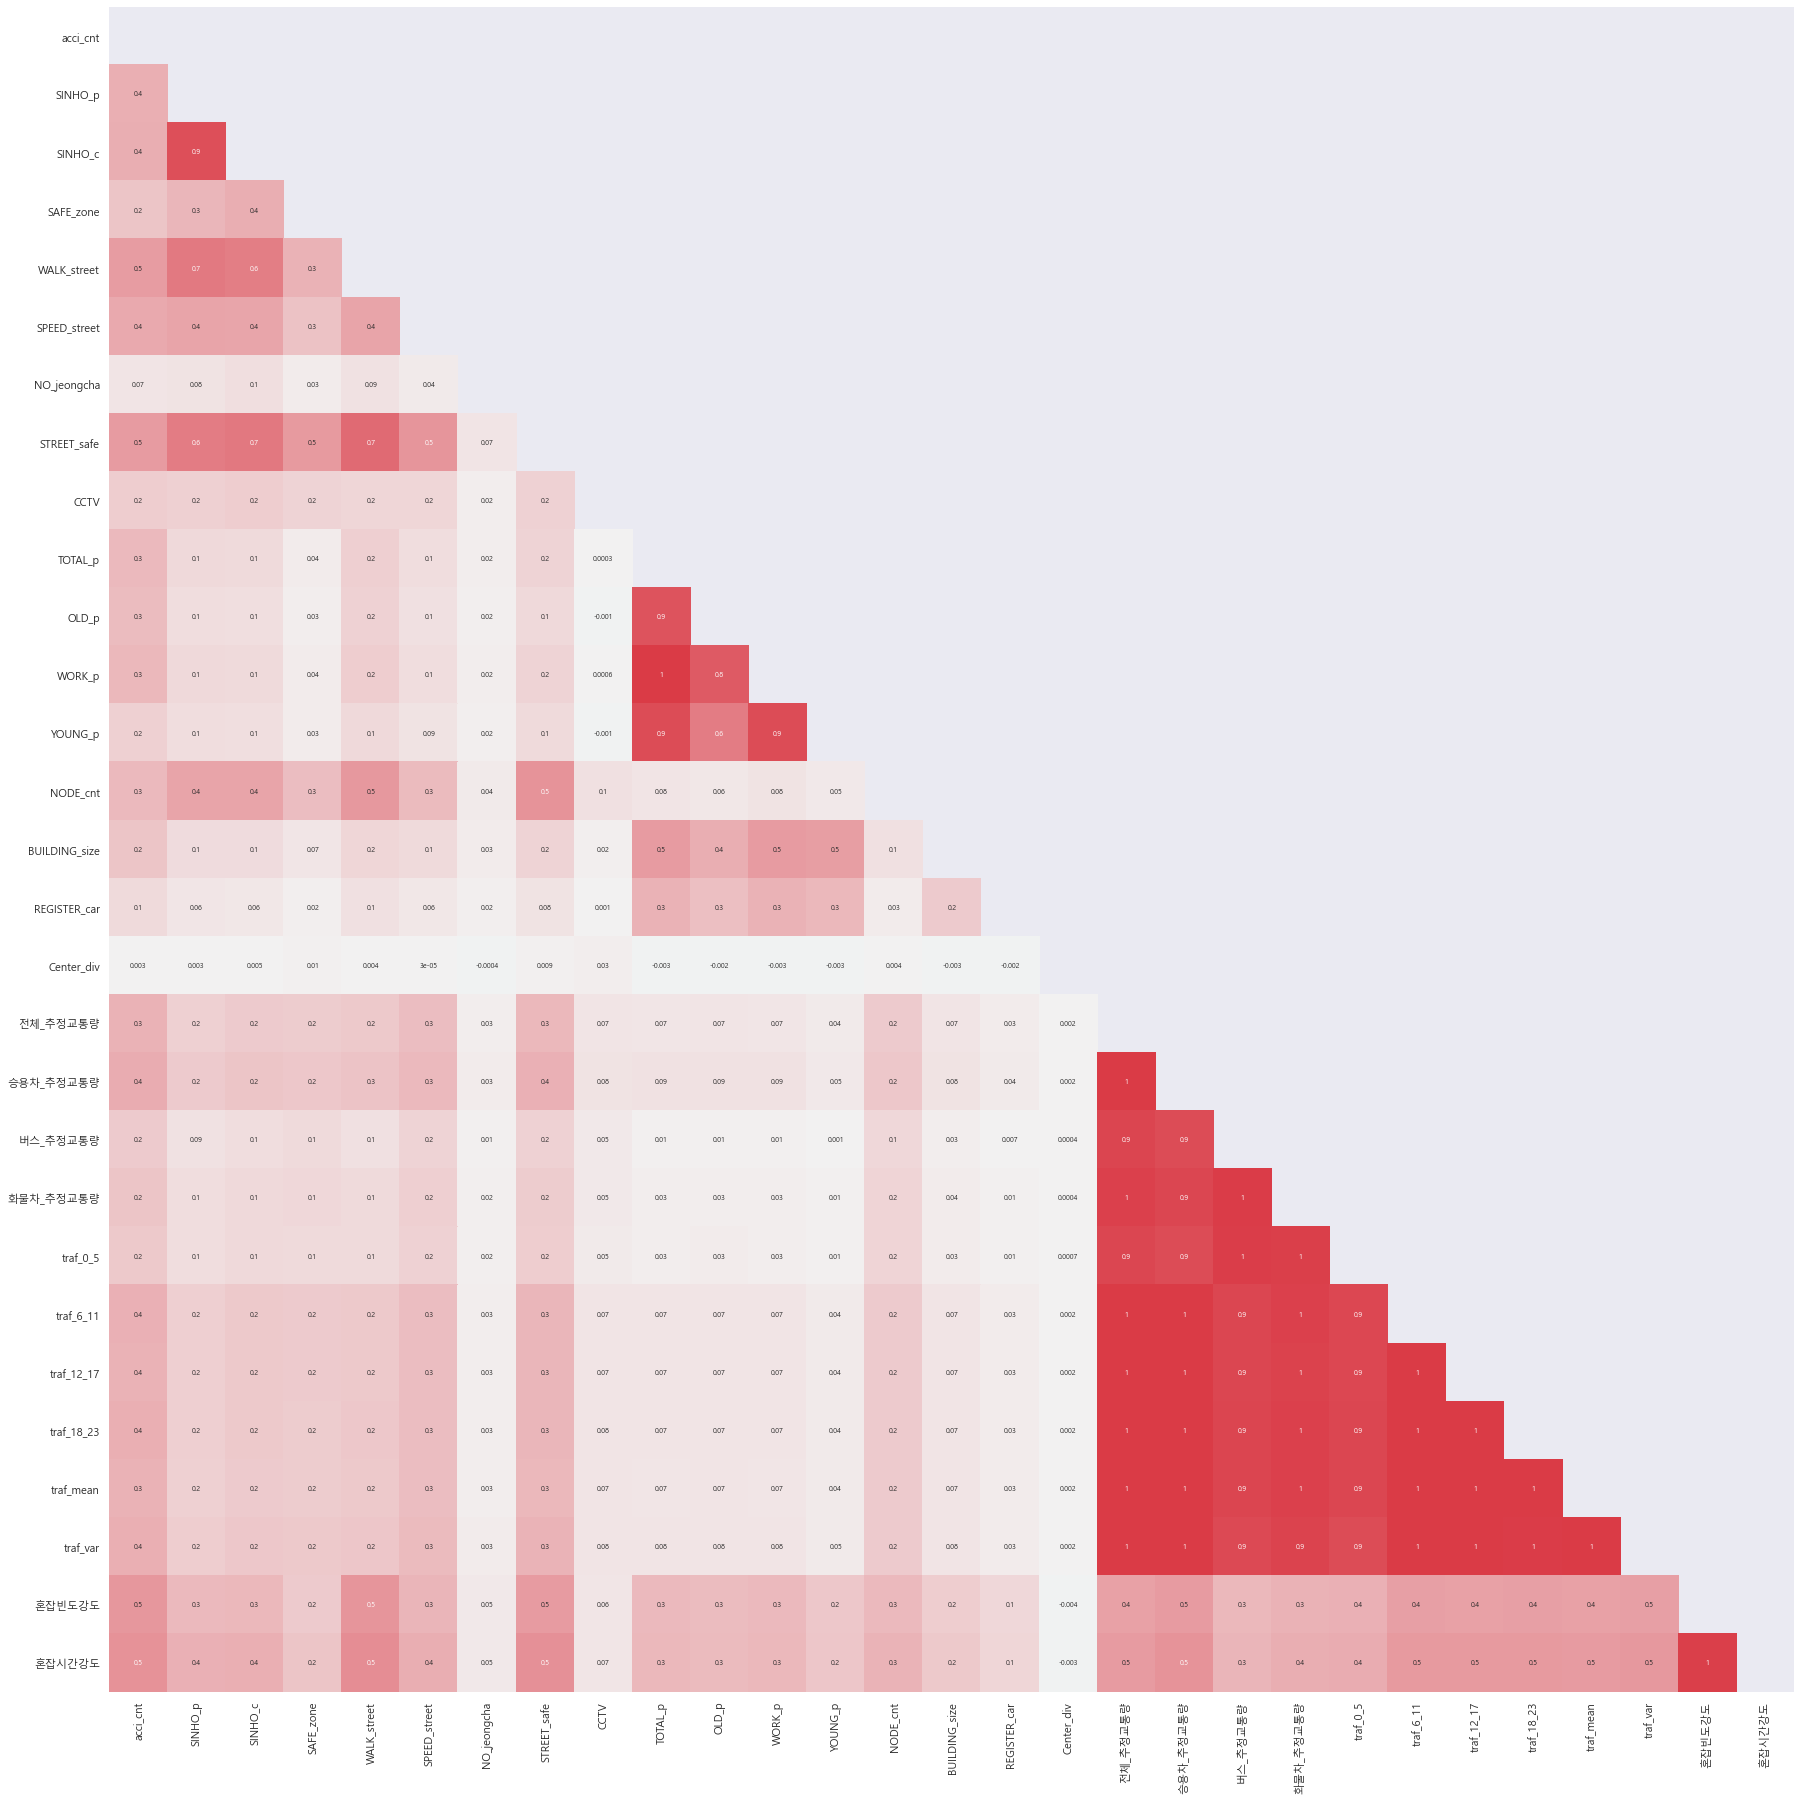

<Figure size 432x288 with 0 Axes>

In [47]:
## correlation plot 

# plot size 설정 
f, ax = plt.subplots(figsize=(31,31))

# upper matrix
matrix = np.triu(data_final.corr())
# palette 
colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(data_final.corr(),
                annot=True, annot_kws={"size": 7}, fmt ='.1g',
                center = 0, vmin=-1, vmax=1, 
                cmap = colormap, cbar = False, #cbar_kws= {'orientation': 'horizontal'} , 
                square = True, mask = matrix)
plt.show()
plt.savefig('data_final_correlation_plot.png')

## 다중공선성 판단기준: VIF 지수 확인 (VIF 10이상 전처리)

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 피처마다의 VIF 계수를 출력합니다.(소수점 4째자리까지만 출력)
pd.options.display.float_format = '{:.4f}'.format

data_final_corr=data_final[['acci_cnt', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'OLD_p', 'WORK_p', 'YOUNG_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_final_corr.values, i) for i in range(data_final_corr.shape[1])]
vif["features"] = data_final_corr.columns
vif

,VIF Factor,features
0,2.1075,acci_cnt
1,5.4511,SINHO_p
2,5.4755,SINHO_c
3,1.3716,SAFE_zone
4,3.0853,WALK_street
5,1.5403,SPEED_street
6,1.0178,NO_jeongcha
7,3.5982,STREET_safe
8,1.0858,CCTV
9,9022.2548,TOTAL_p


지역별 나이대별 인구수 사이의 상관관계가 너무 높아 다중공선성 문제가 발생할 위험이 있기 때문에 지역별 나이대별 인구수는 나이대별 인구수 총합만을 사용하기로 결정하였습니다.

In [49]:
# 먼저 전체인구(TOTAL_p)만 남겨두고 노령인구(OLD_p), 생산인구(WORK_p), 유소년 인구(YOUND_p)는 제외 후 다시 VIF지수 확인

data_final_corr=data_final[['acci_cnt', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_final_corr.values, i) for i in range(data_final_corr.shape[1])]
vif["features"] = data_final_corr.columns
vif

,VIF Factor,features
0,1.9856,acci_cnt
1,5.4481,SINHO_p
2,5.4728,SINHO_c
3,1.3701,SAFE_zone
4,3.0683,WALK_street
5,1.5395,SPEED_street
6,1.0177,NO_jeongcha
7,3.5938,STREET_safe
8,1.0846,CCTV
9,1.6265,TOTAL_p


In [50]:
# 전체 추정교통량만 남겨두고 승용차_추정교통량, 버스_추정교통량, 화물차_추정교통량, traf_0_5, traf_6_11, traf_12_17, traf_18_23 제외 후 다시 VIF지수 확인

data_final_corr=data_final[['acci_cnt', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_final_corr.values, i) for i in range(data_final_corr.shape[1])]
vif["features"] = data_final_corr.columns
vif

,VIF Factor,features
0,1.8638,acci_cnt
1,5.4419,SINHO_p
2,5.4620,SINHO_c
3,1.3679,SAFE_zone
4,3.0601,WALK_street
5,1.5320,SPEED_street
6,1.0171,NO_jeongcha
7,3.5621,STREET_safe
8,1.0837,CCTV
9,1.6234,TOTAL_p


In [51]:
# 전체 추정교통량만 남겨두고 traf_mean, traf_var,혼잡시간강도 제외 후 다시 VIF지수 확인

data_final_corr=data_final[['acci_cnt', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', '혼잡빈도강도']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_final_corr.values, i) for i in range(data_final_corr.shape[1])]
vif["features"] = data_final_corr.columns
vif

,VIF Factor,features
0,1.8382,acci_cnt
1,5.4311,SINHO_p
2,5.4546,SINHO_c
3,1.3644,SAFE_zone
4,3.0450,WALK_street
5,1.5104,SPEED_street
6,1.0169,NO_jeongcha
7,3.4346,STREET_safe
8,1.0818,CCTV
9,1.6189,TOTAL_p


또한  평일 일별 시간대별 교통량와 교통량 데이터의 상관관계가 너무 높아 다중공선성 문제가 발생할 위험이 있기 때문에 승용차,버스,화물차 
추정 교통량 데이터의 합(전체_추정교통량)만을 사용하기로 결정하였습니다. 

### VIF확인 시 전부 10이하로 감소한 것을 확인할 수 있습니다

# 다중공선성 데이터 전처리 후 최종 데이터셋 파일
원하는 대로 csv나 geojson(geometry포함) 파일 선택하면 됨

In [52]:
data_final.columns

Index(['gid', 'acci_cnt', 'geometry', 'SINHO_p', 'SINHO_c', 'SAFE_zone', 'WALK_street', 'SPEED_street', 'NO_jeongcha', 'STREET_safe', 'CCTV', 'TOTAL_p', 'OLD_p', 'WORK_p', 'YOUNG_p', 'NODE_cnt', 'BUILDING_size', 'REGISTER_car', 'Center_div', '전체_추정교통량', '승용차_추정교통량', '버스_추정교통량', '화물차_추정교통량', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23', 'traf_mean', 'traf_var', '혼잡빈도강도', '혼잡시간강도'], dtype='object')

In [69]:
dataset = data_final.drop(['OLD_p','WORK_p','YOUNG_p','화물차_추정교통량','승용차_추정교통량','버스_추정교통량','traf_mean','traf_var','혼잡시간강도', 'traf_0_5', 'traf_6_11', 'traf_12_17', 'traf_18_23'],axis=1)
dataset

,gid,geometry,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도
0,다바866110,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0.0325,0,0,0,0,0,0,0,0,13,0,146.5900,4,0,8283.0000,0.3500
1,다바823157,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",1.5679,3,4,2,3,0,0,14,0,267,1,5944.9800,0,0,1181.6250,21.1575
2,다바928260,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",0.9403,6,5,0,4,3,0,14,0,78,2,1487.4900,40,0,3783.7500,48.0125
3,다바931203,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",3.9797,1,3,1,1,2,0,5,0,0,0,1291.1900,409,0,11596.0000,97.3600
4,다바836109,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2.3527,2,0,0,2,0,0,6,0,396,0,12875.5200,0,0,678.8750,48.4675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54907,다바861065,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ...",0.0225,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54908,다바912036,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54909,다바867189,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54910,다바851062,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000


In [68]:
# geojson 파일로 저장
dataset.drop('geometry',axis=1,inplace=True)
dataset = pd.merge(data_gid,dataset,on='gid')
dataset = gpd.GeoDataFrame(dataset, geometry='geometry')
dataset.to_file('dataset.geojson', driver="GeoJSON",index=False)

dataset

,gid,geometry,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도
0,다바866110,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",0.0325,0,0,0,0,0,0,0,0,13,0,146.5900,4,0,8283.0000,0.3500
1,다바823157,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",1.5679,3,4,2,3,0,0,14,0,267,1,5944.9800,0,0,1181.6250,21.1575
2,다바928260,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",0.9403,6,5,0,4,3,0,14,0,78,2,1487.4900,40,0,3783.7500,48.0125
3,다바931203,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",3.9797,1,3,1,1,2,0,5,0,0,0,1291.1900,409,0,11596.0000,97.3600
4,다바836109,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",2.3527,2,0,0,2,0,0,6,0,396,0,12875.5200,0,0,678.8750,48.4675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54907,다바861065,"MULTIPOLYGON (((127.34527 36.25565, 127.34527 ...",0.0225,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54908,다바912036,"MULTIPOLYGON (((127.40208 36.22956, 127.40207 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54909,다바867189,"MULTIPOLYGON (((127.35174 36.36745, 127.35174 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000
54910,다바851062,"MULTIPOLYGON (((127.33415 36.25293, 127.33415 ...",0.0000,0,0,0,0,0,0,0,0,0,0,0.0000,0,0,0.0000,0.0000


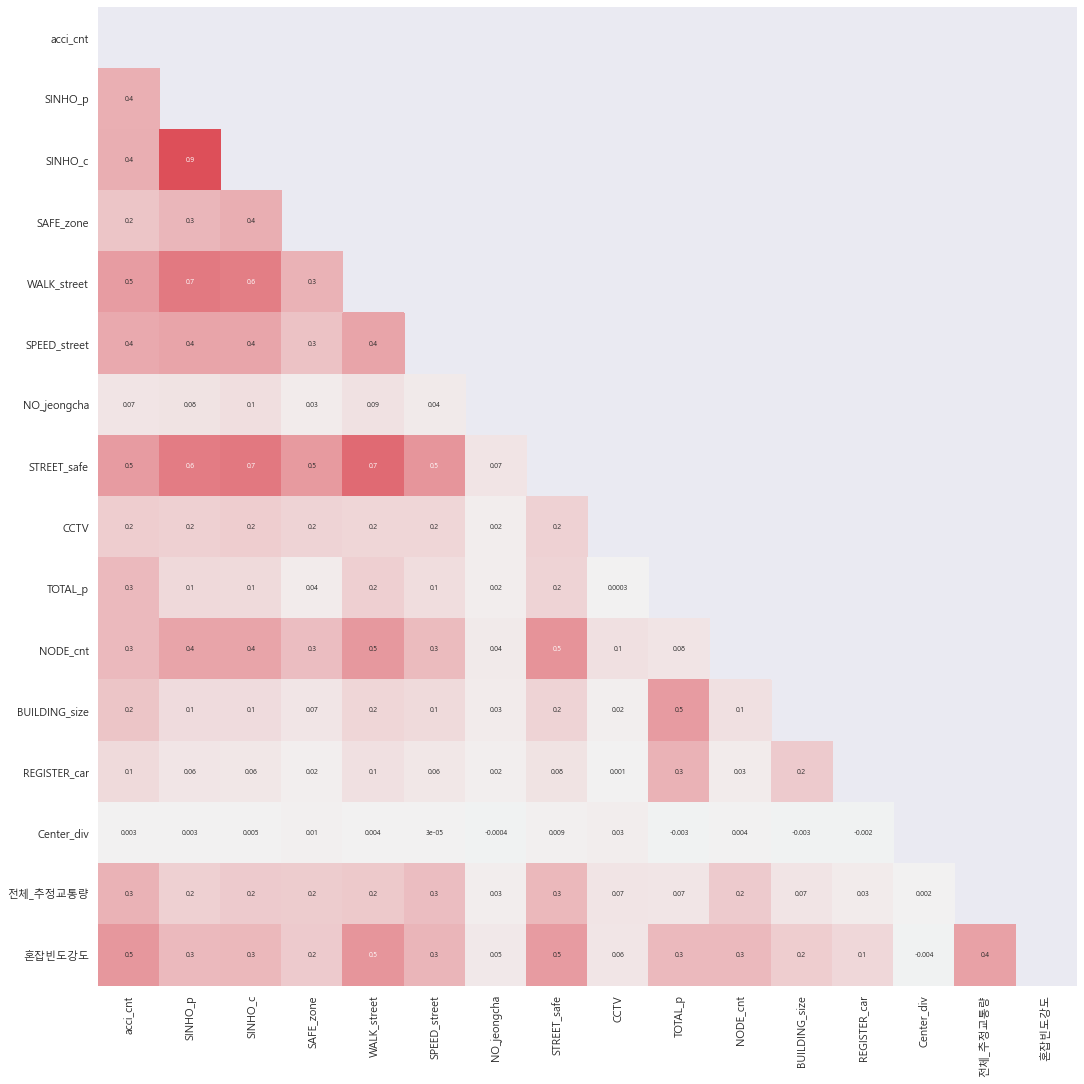

<Figure size 432x288 with 0 Axes>

In [59]:
## correlation plot 

# plot size 설정 
f, ax = plt.subplots(figsize=(18,18))

# upper matrix
matrix = np.triu(dataset.corr())
# palette 
colormap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(dataset.corr(),
                annot=True, annot_kws={"size": 7}, fmt ='.1g',
                center = 0, vmin=-1, vmax=1, 
                cmap = colormap, cbar = False, #cbar_kws= {'orientation': 'horizontal'} , 
                square = True, mask = matrix)
plt.show()
plt.savefig('dataset_correlation_plot.png')

# 모델링(regressor)

In [2]:
import os
import random
rs = 123
np.random.seed(rs)
random.seed(rs)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.linear_model import *
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import *
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

## 데이터 불러오기

In [24]:
data_weather = pd.read_csv('data_weather.csv')
data_final=gpd.read_file('dataset.geojson')

In [25]:
data_weather.columns

Index(['사고일', '시군구', '사고유형', '법규위반', '사고내용', '사망자수', '중상자수', '경상자수', '부상신고자수', '가해운전자 차종', '가해운전자 연령대', '가해운전자 성별', '피해운전자 차종', '피해운전자 연령대', '피해운전자 성별', 'gid', '구', '동', '세부사고유형', '사고월', '사고연도', '사고연월', '평균기온(°C)', '최저기온(°C)', '최고기온(°C)', '일강수량(mm)', '최대 풍속(m/s)', '최대 풍속 풍향(16방위)', '평균 풍속(m/s)', '평균 상대습도(%)', '일 최심적설(cm)', '평균 지면온도(°C)', '안개 계속시간(hr)'], dtype='object')

In [26]:
data_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 54912 entries, 0 to 54911
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   gid            54912 non-null  object  
 1   acci_cnt       54912 non-null  float64 
 2   SINHO_p        54912 non-null  int64   
 3   SINHO_c        54912 non-null  int64   
 4   SAFE_zone      54912 non-null  int64   
 5   WALK_street    54912 non-null  int64   
 6   SPEED_street   54912 non-null  int64   
 7   NO_jeongcha    54912 non-null  int64   
 8   STREET_safe    54912 non-null  int64   
 9   CCTV           54912 non-null  int64   
 10  TOTAL_p        54912 non-null  int64   
 11  NODE_cnt       54912 non-null  int64   
 12  BUILDING_size  54912 non-null  float64 
 13  REGISTER_car   54912 non-null  int64   
 14  Center_div     54912 non-null  int64   
 15  전체_추정교통량       54912 non-null  float64 
 16  혼잡빈도강도         54912 non-null  float64 
 17  geometry       54912 no

### gid 기준으로 그룹화

In [27]:
Victims = data_weather.groupby(data_weather['gid']).sum()[['사망자수', '중상자수', '경상자수', '부상신고자수']]
Victims 

,사망자수,중상자수,경상자수,부상신고자수
gid,,,,
다바780093,0,0,1,0
다바781090,0,0,2,0
다바781091,0,3,1,2
다바787132,0,1,0,0
다바787134,0,2,1,0
...,...,...,...,...
라바010169,1,0,6,0
라바016173,0,1,0,0
라바024244,1,0,0,0


In [28]:
rain_snow = data_weather.groupby(data_weather['gid']).sum()[['일강수량(mm)','일 최심적설(cm)']]/3
rain_snow 

,일강수량(mm),일 최심적설(cm)
gid,,
다바780093,0.000000,0.0
다바781090,0.000000,0.0
다바781091,0.000000,0.0
다바787132,0.000000,0.0
다바787134,8.933333,0.0
...,...,...
라바010169,0.333333,0.0
라바016173,0.000000,0.0
라바024244,0.000000,0.0


In [29]:
fog = data_weather.groupby(data_weather['gid']).mean()['안개 계속시간(hr)']

In [30]:
data_weather_edit = pd.concat([Victims,rain_snow,fog],axis=1)
data_weather_edit.reset_index(inplace=True)
data_weather_edit

,gid,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr)
0,다바780093,0,0,1,0,0.000000,0.0,0.0
1,다바781090,0,0,2,0,0.000000,0.0,0.0
2,다바781091,0,3,1,2,0.000000,0.0,0.0
3,다바787132,0,1,0,0,0.000000,0.0,0.0
4,다바787134,0,2,1,0,8.933333,0.0,0.0
...,...,...,...,...,...,...,...,...
5934,라바010169,1,0,6,0,0.333333,0.0,0.0
5935,라바016173,0,1,0,0,0.000000,0.0,0.0
5936,라바024244,1,0,0,0,0.000000,0.0,0.0
5937,라바033232,0,0,2,0,0.000000,0.0,0.0


#### 1,2번 데이터 합치기

In [31]:
data_final = pd.merge(data_final,data_weather_edit, on= 'gid',how='left')
#data_final = data_final[data_final['acci_cnt']>=1]
data_final.head()

,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,geometry,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr)
0,다바866110,0.032538,0,0,0,0,0,0,0,0,13,0,146.59,4,0,8283.000,0.3500,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,다바823157,1.567877,3,4,2,3,0,0,14,0,267,1,5944.98,0,0,1181.625,21.1575,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,다바928260,0.940304,6,5,0,4,3,0,14,0,78,2,1487.49,40,0,3783.750,48.0125,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,다바931203,3.979689,1,3,1,1,2,0,5,0,0,0,1291.19,409,0,11596.000,97.3600,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ...",0.0,1.0,1.0,0.0,1.4,1.1,0.0
4,다바836109,2.352736,2,0,0,2,0,0,6,0,396,0,12875.52,0,0,678.875,48.4675,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
data_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 54912 entries, 0 to 54911
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   gid            54912 non-null  object  
 1   acci_cnt       54912 non-null  float64 
 2   SINHO_p        54912 non-null  int64   
 3   SINHO_c        54912 non-null  int64   
 4   SAFE_zone      54912 non-null  int64   
 5   WALK_street    54912 non-null  int64   
 6   SPEED_street   54912 non-null  int64   
 7   NO_jeongcha    54912 non-null  int64   
 8   STREET_safe    54912 non-null  int64   
 9   CCTV           54912 non-null  int64   
 10  TOTAL_p        54912 non-null  int64   
 11  NODE_cnt       54912 non-null  int64   
 12  BUILDING_size  54912 non-null  float64 
 13  REGISTER_car   54912 non-null  int64   
 14  Center_div     54912 non-null  int64   
 15  전체_추정교통량       54912 non-null  float64 
 16  혼잡빈도강도         54912 non-null  float64 
 17  geometry       54912 no

In [33]:
data_final = data_final.fillna(0)
data_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 54912 entries, 0 to 54911
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   gid            54912 non-null  object  
 1   acci_cnt       54912 non-null  float64 
 2   SINHO_p        54912 non-null  int64   
 3   SINHO_c        54912 non-null  int64   
 4   SAFE_zone      54912 non-null  int64   
 5   WALK_street    54912 non-null  int64   
 6   SPEED_street   54912 non-null  int64   
 7   NO_jeongcha    54912 non-null  int64   
 8   STREET_safe    54912 non-null  int64   
 9   CCTV           54912 non-null  int64   
 10  TOTAL_p        54912 non-null  int64   
 11  NODE_cnt       54912 non-null  int64   
 12  BUILDING_size  54912 non-null  float64 
 13  REGISTER_car   54912 non-null  int64   
 14  Center_div     54912 non-null  int64   
 15  전체_추정교통량       54912 non-null  float64 
 16  혼잡빈도강도         54912 non-null  float64 
 17  geometry       54912 no

## 모델링용 데이터셋 만들기

In [34]:
data_final.to_csv('real_final_set.csv',header=True,index=False)
final_set_geo = gpd.GeoDataFrame(data_final, geometry='geometry')
final_set_geo.to_file('real_final_set.geojson', driver= 'GeoJSON')

## 문자열 데이터를 라벨 인코딩

In [3]:
final = gpd.read_file('real_final_set.geojson')

In [4]:
final_encode = pd.DataFrame()
for col in tqdm(final.columns):
    if type(final[col][0]) == str:
        if col == 'gid':
            gid_lbe = LabelEncoder()
            gid_lbe.fit(final[col])
            final_encode[col] = gid_lbe.transform(final[col])
        else : 
            lbe = LabelEncoder()
            lbe.fit(final[col])
            final_encode[col] = lbe.transform(final[col])
    else:
        final_encode[col] = final[col]
final_encode.head()

100%|██████████| 25/25 [00:00<00:00, 190.26it/s]


,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),geometry
0,16908,0.032538,0,0,0,0,0,0,0,0,13,0,146.59,4,0,8283.000,0.3500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ..."
1,6376,1.567877,3,4,2,3,0,0,14,0,267,1,5944.98,0,0,1181.625,21.1575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ..."
2,33747,0.940304,6,5,0,4,3,0,14,0,78,2,1487.49,40,0,3783.750,48.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ..."
3,34521,3.979689,1,3,1,1,2,0,5,0,0,0,1291.19,409,0,11596.000,97.3600,0.0,1.0,1.0,0.0,1.4,1.1,0.0,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ..."
4,9247,2.352736,2,0,0,2,0,0,6,0,396,0,12875.52,0,0,678.875,48.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ..."


In [5]:
X = final_encode.drop(['acci_cnt','geometry'], axis = 1)
y = final_encode['acci_cnt']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 4)

## 모델학습
### 1. Linear Regression

In [48]:
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_train)

print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = lm.predict(X_test)
acc_linreg = metrics.r2_score(y_test, y_test_pred)
print('\nTest score')
print('R^2:', acc_linreg)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.6650980041145775
Adjusted R^2: 0.6648974848792633
MAE: 1.4741923752503001
MSE: 12.965607818017357
RMSE: 3.6007787793777832


### 2. Random Forest Regressor

In [50]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)

print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = rf.predict(X_test)

acc_rf = metrics.r2_score(y_test, y_test_pred)
print('\nTest score')
print('R^2:', acc_rf)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.966992260285063
Adjusted R^2: 0.9669724972295769
MAE: 0.3851420901131171
MSE: 1.2778825249207704
RMSE: 1.1304346619423744


In [53]:
f1 = pd.DataFrame({'data': X.columns, 'importance': reg.feature_importances_}).sort_values(by='importance', ascending=False)

In [54]:
f1.head(10)

,data,importance
18,경상자수,0.614600
9,TOTAL_p,0.094446
11,BUILDING_size,0.055548
0,gid,0.050805
15,혼잡빈도강도,0.035023
14,전체_추정교통량,0.029874
12,REGISTER_car,0.024202
7,STREET_safe,0.015491
20,일강수량(mm),0.013950
2,SINHO_c,0.013322


### 3. XGBRegressor

In [10]:
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree','gblinear']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]
base_score = [0.1,0.25,0.5]
n_estimators = [100, 500, 900, 1100, 1500]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth':max_depth,
                       'learning_rate':learning_rate,
                       'min_child_weight':min_child_weight,
                       'booster':booster,
                       'base_score':base_score}

regressor = XGBRegressor()
gd=RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,verbose=True)

gd.fit(X_train,y_train)

print(gd.best_score_)
print(gd.best_estimator_)
best_xgb= gd.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[11:30:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:30:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:30:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { max_depth, min_child_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

KeyboardInterrupt: 

In [ ]:
best_xgb.fit(X_train,y_train)

y_pred = best_xgb.predict(X_train)
print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = xgb.predict(X_test)
print('\nTest score')
acc_xgb = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_svm)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

### 4. LightGBM

In [58]:
train = lgb.Dataset(X_train, label = y_train) 
test = lgb.Dataset(X_test, label = y_test)

base_score = [0.1,0.25,0.5]
booster=['gbtree','gblinear']
max_depth = [2, 3, 5, 10, 15]
min_child_weight=[1,2,3,4]
n_estimators = [100, 500, 900, 1100, 1500]
params = {'base_score':base_score,
          'booster':booster,
          'max_depth':max_depth,
          'min_child_weight':min_child_weight,
          'n_estimators':n_estimators
         }

regressor = lgb.LGBMRegressor()
gd=RandomizedSearchCV(estimator=regressor,param_distributions=hyperparameter_grid,verbose=True)
gd.fit(X_train,y_train)
print(gd.best_score_)
print(gd.best_estimator_)
best_lgb = gd.best_estimator_

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006039 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2133
[LightGBM] [Info] Number of data points in the train set: 38438, number of used features: 22
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.036237
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 14.1875


KeyboardInterrupt: 

In [ ]:
best_lgb.fit(X_train,y_train)
y_pred = best_lgb.predict(X_train)
print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = best_lgb.predict(X_test)

print('\nTest score')
acc_lgb = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_lgb)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

### 5. SVM Regressor

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
svma = svm.SVR()
svma.fit(X_train, y_train)
y_pred = svma.predict(X_train)

print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = svma.predict(X_test)

acc_svm = metrics.r2_score(y_test, y_test_pred)
print('\nTest score')
print('R^2:', acc_svm)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

R^2: 0.5100464537668294
Adjusted R^2: 0.5097530989596404
MAE: 1.2251735221151452
MSE: 18.968371665600564
RMSE: 4.355269413664391


### 6. Voting

In [ ]:
#Voting할 모델 선택
r1 = best_xgb
r2 = RandomForestRegressor()
r3 = best_lgb
r4 = GradientBoostingRegressor()

vreg = VotingRegressor([('xgb', r1), ('rf', r2),('lgbm',r3),('gb',r4)],weights=[1,0.8,0.8,0.7])

vreg.fit(X_train,y_train)
y_pred = vreg.predict(X_train)
print('Train score')
print('R^2:',metrics.r2_score(y_train, y_pred))
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_train, y_pred))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_train, y_pred))
print('MSE:',metrics.mean_squared_error(y_train, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_train, y_pred)))

y_test_pred = vreg.predict(X_test)
print('\nTest score')
acc_vot = metrics.r2_score(y_test, y_test_pred)
print('R^2:', acc_vot)
print('Adjusted R^2:',1 - (1-metrics.r2_score(y_test, y_test_pred))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
print('MAE:',metrics.mean_absolute_error(y_test, y_test_pred))
print('MSE:',metrics.mean_squared_error(y_test, y_test_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

### 결과 종합

In [42]:
models = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'lightGBM','Support Vector Machines','Voting'],
    'R-squared Score': [acc_linreg*100, acc_rf*100, acc_xgb*100, acc_lgb*100,acc_svm*100,acc_vot*100]})
models.sort_values(by='R-squared Score', ascending=False)

,Model,R-squared Score
2,XGBoost,75.495018
1,Random Forest,74.734445
0,Linear Regression,63.812541
3,Support Vector Machines,49.051729


## 상위 100개소 예측하기
- 모델링한 결과중 가장 잘 나온 XGBOOST를 사용하기로 함

In [11]:
#가장 잘 나온 모델인 best_xgb로 예측
final_encode['pred']=  best_xgb.predict(X.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
#라벨인코더로 돌린 GID 복원
final_encode['gid'] = gid_lbe.inverse_transform(final_encode['gid'])

In [18]:
final_encode.head()

,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),geometry
0,다바866110,0.032538,0,0,0,0,0,0,0,0,13,0,146.59,4,0,8283.000,0.3500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.35076 36.29622, 127.35076 ..."
1,다바823157,1.567877,3,4,2,3,0,0,14,0,267,1,5944.98,0,0,1181.625,21.1575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.30277 36.33853, 127.30276 ..."
2,다바928260,0.940304,6,5,0,4,3,0,14,0,78,2,1487.49,40,0,3783.750,48.0125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.41967 36.43152, 127.41967 ..."
3,다바931203,3.979689,1,3,1,1,2,0,5,0,0,0,1291.19,409,0,11596.000,97.3600,0.0,1.0,1.0,0.0,1.4,1.1,0.0,"MULTIPOLYGON (((127.42307 36.38013, 127.42307 ..."
4,다바836109,2.352736,2,0,0,2,0,0,6,0,396,0,12875.52,0,0,678.875,48.4675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((127.31735 36.29527, 127.31735 ..."


In [6]:
final_map = pd.read_csv('map.csv')
final_map.head()

,Unnamed: 0,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,geometry,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),pred
0,0,다바866110,0.032538,0,0,0,0,0,0,0,0,13,0,146.59,4,0,8283.000,0.3500,16958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.944621
1,1,다바823157,1.567877,3,4,2,3,0,0,14,0,267,1,5944.98,0,0,1181.625,21.1575,6172,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.098565
2,2,다바928260,0.940304,6,5,0,4,3,0,14,0,78,2,1487.49,40,0,3783.750,48.0125,33503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.634786
3,3,다바931203,3.979689,1,3,1,1,2,0,5,0,0,0,1291.19,409,0,11596.000,97.3600,34390,0.0,1.0,1.0,0.0,1.4,1.1,0.0,14.574604
4,4,다바836109,2.352736,2,0,0,2,0,0,6,0,396,0,12875.52,0,0,678.875,48.4675,9126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.665079


In [7]:
final_encode['pred'] = final_map['pred']

In [8]:
#로드한 데이터를 geoDataFrame으로 변경
final_geo = gpd.GeoDataFrame(final_encode, geometry='geometry')

In [9]:
#예측치를 기준으로 정렬
final_geo_sort = final_geo.sort_values(by='pred',ascending=False)

In [10]:
# 각 구역의 중심점을 기준으로 50m반경으로 도형 구하기
final_geo_sort['X좌표(경도)'] = final_geo_sort['geometry'].centroid.x
final_geo_sort['Y좌표(위도)'] = final_geo_sort['geometry'].centroid.y
final_geo_sort['geometry'] = final_geo_sort['geometry'].centroid.buffer(0.0005)
final_geo_sort.head()

,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),geometry,pred,X좌표(경도),Y좌표(위도)
2721,22925,179.346905,0,0,0,0,0,0,0,0,16,0,1910.59,8,0,0.000000,0.000000,0.0,4.0,57.0,2.0,100.966667,0.033333,0.134259,"POLYGON ((127.37735 36.35080, 127.37735 36.350...",146.61462,127.376848,36.350796
6782,23429,83.759594,2,1,1,3,7,0,14,0,0,1,14588.23,0,0,9704.500000,59.680000,0.0,7.0,43.0,3.0,28.833333,2.566667,0.102059,"POLYGON ((127.37958 36.35170, 127.37957 36.351...",132.56438,127.379076,36.351700
2237,26667,35.667425,0,0,0,1,4,0,1,0,9,0,369.20,1,0,20210.250000,99.817500,0.0,0.0,21.0,5.0,13.233333,0.000000,0.320769,"POLYGON ((127.39300 36.31745, 127.39299 36.317...",132.30356,127.392497,36.317454
2889,15357,42.211603,3,0,4,4,4,0,7,2,0,0,1950.91,1,0,11034.423077,26.975000,0.0,1.0,21.0,4.0,43.666667,0.000000,0.000000,"POLYGON ((127.34501 36.36158, 127.34500 36.361...",131.67169,127.344507,36.361577
8630,22426,59.104796,0,0,0,1,0,0,2,0,355,0,481.99,44,0,3254.000000,78.038333,0.0,5.0,27.0,1.0,44.566667,2.300000,0.075909,"POLYGON ((127.37513 36.34719, 127.37512 36.347...",131.05275,127.374625,36.347187


In [11]:
ECLO = pd.DataFrame(final_geo_sort['부상신고자수'] + 3 * final_geo_sort['경상자수'] + \
                        5 * final_geo_sort['중상자수'] + 10 * final_geo_sort['사망자수'])
mm_scaler = MinMaxScaler()
final_geo_sort['ECLO_reg'] = mm_scaler.fit_transform(ECLO)
final_geo_sort['target_reg'] = final_geo_sort['pred'] * final_geo_sort['ECLO_reg'] 

In [12]:
final_geo_sort_t= final_geo_sort.sort_values(by='target_reg',ascending=False)

In [13]:
#결과 비교를 위해 R로 만든 결과파일을 로드함.
R_final = gpd.read_file('result1_data.geojson')
R_final['X좌표(경도)'] = final_geo_sort['geometry'].centroid.x
R_final['Y좌표(위도)'] = final_geo_sort['geometry'].centroid.y
R_final['geometry'] = R_final['geometry'].centroid.buffer(0.0005)
R_final = R_final.drop_duplicates('gid')
R_final.head()

,gid,acci_cnt,SAFE_zone,pred,PSI,danger_score,geometry,X좌표(경도),Y좌표(위도)
0,다바911163,48,0,26.441173,21.558827,16.425773,"POLYGON ((127.40188 36.34451, 127.40187 36.344...",127.351318,36.296674
48,다바888170,63,0,55.908979,7.091021,7.091021,"POLYGON ((127.37623 36.35079, 127.37623 36.350...",127.326734,36.333604
49,다바905178,34,0,22.764647,11.235353,6.063524,"POLYGON ((127.39517 36.35803, 127.39517 36.357...",127.361357,36.287671
81,다바849187,30,1,19.812698,10.187302,4.851096,"POLYGON ((127.33274 36.36607, 127.33273 36.366...",127.306631,36.352506
89,다바904196,31,0,21.568099,9.431901,4.641094,"POLYGON ((127.39403 36.37425, 127.39403 36.374...",127.424687,36.438284


In [14]:
R_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5771 entries, 0 to 23308
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   gid           5771 non-null   object  
 1   acci_cnt      5771 non-null   int64   
 2   SAFE_zone     5771 non-null   int64   
 3   pred          5771 non-null   float64 
 4   PSI           5771 non-null   float64 
 5   danger_score  5771 non-null   float64 
 6   geometry      5771 non-null   geometry
 7   X좌표(경도)       5771 non-null   float64 
 8   Y좌표(위도)       5771 non-null   float64 
dtypes: float64(5), geometry(1), int64(2), object(1)
memory usage: 450.9+ KB


In [15]:
python_geo = gpd.GeoDataFrame(final_geo_sort_t[['gid','X좌표(경도)','Y좌표(위도)','pred','geometry']].head(100), geometry='geometry')
python_geo.to_file('python_submission.geojson', driver="GeoJSON",index=False)

In [16]:
python_geo = gpd.GeoDataFrame(R_final.head(100), geometry='geometry')
python_geo.to_file('R_submission.geojson', driver="GeoJSON",index=False)

In [17]:
python_geo = final_geo_sort_t[['gid','X좌표(경도)','Y좌표(위도)','pred','geometry']].head(100)
R_geo = R_final.head(100)
python_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 100 entries, 1606 to 10042
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   gid       100 non-null    int64   
 1   X좌표(경도)   100 non-null    float64 
 2   Y좌표(위도)   100 non-null    float64 
 3   pred      100 non-null    float64 
 4   geometry  100 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 4.7 KB


In [18]:
python_geo.to_csv('python_submission.csv',header=True,index=False)

In [19]:
R_geo.to_csv('R_submission.csv',header=True,index=False)

In [17]:
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

center = (36.35, 127.4)
zoom = 12

# Create the map
m = folium.Map(location = center, 
               zoom_start = zoom,
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/BB730805-E115-3140-9139-BB79B7E3B74F/Base/{z}/{y}/{x}.png',
               attr = '대전시'
              )

# Add points to the map
mc = MarkerCluster()
for idx, row in python_submission.iterrows():
    mc.add_child(Marker([row['Y좌표(위도)'], row['X좌표(경도)']]))
m.add_child(mc)

mc2 = MarkerCluster()
for idx, row in R_submission.iterrows():
    mc2.add_child(Marker([row['Y좌표(위도)'], row['X좌표(경도)']]))
m.add_child(mc)
# Display the map
m

In [33]:
data25 = gpd.read_file('25.대전광역시_법정경계(시군구).geojson')

In [22]:
import folium

#대전시 중앙으로 오게 설정
center = (36.35, 127.4)
zoom = 12

#folium.Map으로 지도 그리기
m = folium.Map(location = center, 
               zoom_start = zoom,
               tiles = 'http://api.vworld.kr/req/wmts/1.0.0/BB730805-E115-3140-9139-BB79B7E3B74F/Base/{z}/{y}/{x}.png',
               attr = '대전시'
              )

#geojson에서 받은 값중 상위 100개만 지도에 표시
blue = {'fillColor': '#1e90ff', 'color': '#1e90ff'}
red = {'fillColor': '#E5142D', 'color': '#E5142D'}
green = {'fillColor': '#11A31500', 'color': '#11A31566'}

#folium.GeoJson(data25,name='test3', style_function=lambda x:green).add_to(m)
folium.GeoJson(final_geo_sort_t.head(100),name='test2', style_function=lambda x:red).add_to(m)
folium.GeoJson(R_final.head(100),name='test1', style_function=lambda x:blue).add_to(m)



m

In [20]:
import folium

#대전시 중앙으로 오게 설정
center = (36.35, 127.4)
zoom = 12

#folium.Map으로 지도 그리기
m = folium.Map(location = center, 
               zoom_start = zoom,
               tiles = 'cartodbpositron',
               attr = '대전시'
              )

#geojson에서 받은 값중 상위 100개만 지도에 표시
blue = {'fillColor': '#1e90ff', 'color': '#1e90ff'}
red = {'fillColor': '#E5142D', 'color': '#E5142D'}
green = {'fillColor': '#11A31500', 'color': '#11A31566'}

folium.GeoJson(data25,name='test3', style_function=lambda x:green).add_to(m)
#folium.GeoJson(R_final.head(100),name='test1', style_function=lambda x:blue).add_to(m)
folium.GeoJson(final_geo_sort_t.head(100),name='test2', style_function=lambda x:red).add_to(m)



m

NameError: name 'data25' is not defined

## csv파일로 저장하기
### 1) 파이썬 머신러닝 모델

In [44]:
submission = final_geo_sort_t.head(100)

In [19]:
data18 = gpd.read_file('18.대전광역시_교통노드(2018).geojson')

In [45]:
submission.head()

,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),geometry,pred,X좌표(경도),Y좌표(위도),ECLO_reg,target_reg
1606,8221,60.298975,8,7,0,6,4,0,17,0,0,1,999.68,0,0,20155.600000,47.556000,1.0,13.0,83.0,5.0,69.900000,1.733333,0.003269,"POLYGON ((127.31260 36.39579, 127.31260 36.395...",113.25408,127.312100,36.395788,1.000000,113.254080
450,29839,68.094892,4,5,0,8,0,0,15,0,7,1,561.30,13,0,16193.687500,54.923125,0.0,18.0,57.0,2.0,62.733333,2.866667,0.132979,"POLYGON ((127.40524 36.32828, 127.40524 36.328...",123.05855,127.404738,36.328283,0.799392,98.372032
4837,39034,71.988504,4,5,7,4,4,0,17,0,0,1,1160.37,1,0,13793.600000,30.619500,0.0,12.0,67.0,3.0,53.400000,0.733333,0.035385,"POLYGON ((127.44199 36.35084, 127.44199 36.350...",121.85526,127.441489,36.350845,0.802432,97.780513
1576,22923,141.728329,5,11,5,7,6,0,26,0,0,2,10805.13,1,0,14257.047619,46.679286,0.0,16.0,69.0,2.0,57.100000,0.000000,0.168824,"POLYGON ((127.37735 36.34899, 127.37735 36.348...",109.51991,127.376851,36.348993,0.878419,96.204419
7038,13774,67.509479,6,11,0,7,0,0,20,2,0,1,1035.50,5,0,17333.307692,55.705000,0.0,13.0,65.0,0.0,37.400000,2.100000,0.125957,"POLYGON ((127.33831 36.36427, 127.33831 36.364...",119.12240,127.337813,36.364272,0.790274,94.139283


#### 해당 지역 일대 노드 파악

In [46]:
placename_list = []
for i in tqdm(range(submission.shape[0])): 
    area = submission ['geometry'].iloc[i]
    place = data18[data18['geometry'].within(area)]
    element = place["NODE_NAME"].values
    placename_list.append(element)

100%|██████████| 100/100 [00:00<00:00, 441.19it/s]


In [47]:
placename = []
for i in tqdm(range(len(placename_list))):
    if len(placename_list[i]) == 0:
        placename.append('-')
    else :
        arr = placename_list[i]
        placename.append(str(arr[0]))

100%|██████████| 100/100 [00:00<00:00, 304597.24it/s]


In [48]:
submission['시설명/주소지'] = placename
submission['반경'] = '50m'
submission.head()

,gid,acci_cnt,SINHO_p,SINHO_c,SAFE_zone,WALK_street,SPEED_street,NO_jeongcha,STREET_safe,CCTV,TOTAL_p,NODE_cnt,BUILDING_size,REGISTER_car,Center_div,전체_추정교통량,혼잡빈도강도,사망자수,중상자수,경상자수,부상신고자수,일강수량(mm),일 최심적설(cm),안개 계속시간(hr),geometry,pred,X좌표(경도),Y좌표(위도),ECLO_reg,target_reg,시설명/주소지,반경
1606,8221,60.298975,8,7,0,6,4,0,17,0,0,1,999.68,0,0,20155.600000,47.556000,1.0,13.0,83.0,5.0,69.900000,1.733333,0.003269,"POLYGON ((127.31260 36.39579, 127.31260 36.395...",113.25408,127.312100,36.395788,1.000000,113.254080,외삼네거리,50m
450,29839,68.094892,4,5,0,8,0,0,15,0,7,1,561.30,13,0,16193.687500,54.923125,0.0,18.0,57.0,2.0,62.733333,2.866667,0.132979,"POLYGON ((127.40524 36.32828, 127.40524 36.328...",123.05855,127.404738,36.328283,0.799392,98.372032,동서로네거리,50m
4837,39034,71.988504,4,5,7,4,4,0,17,0,0,1,1160.37,1,0,13793.600000,30.619500,0.0,12.0,67.0,3.0,53.400000,0.733333,0.035385,"POLYGON ((127.44199 36.35084, 127.44199 36.350...",121.85526,127.441489,36.350845,0.802432,97.780513,-,50m
1576,22923,141.728329,5,11,5,7,6,0,26,0,0,2,10805.13,1,0,14257.047619,46.679286,0.0,16.0,69.0,2.0,57.100000,0.000000,0.168824,"POLYGON ((127.37735 36.34899, 127.37735 36.348...",109.51991,127.376851,36.348993,0.878419,96.204419,계룡로네거리,50m
7038,13774,67.509479,6,11,0,7,0,0,20,2,0,1,1035.50,5,0,17333.307692,55.705000,0.0,13.0,65.0,0.0,37.400000,2.100000,0.125957,"POLYGON ((127.33831 36.36427, 127.33831 36.364...",119.12240,127.337813,36.364272,0.790274,94.139283,궁동네거리,50m


In [49]:
final_submission = submission[['시설명/주소지','X좌표(경도)','Y좌표(위도)','반경']]
#기존 인덱스 정리
final_submission.reset_index(inplace=True,drop=True)

#인덱스 한번 더 정리해서 위험순위 column 생성
final_submission.reset_index(inplace=True)
final_submission.rename(columns = {'index' : '위험순위'}, inplace = True)
final_submission['위험순위'] = final_submission['위험순위'] + 1
final_submission.head()

,위험순위,시설명/주소지,X좌표(경도),Y좌표(위도),반경
0,1,외삼네거리,127.312100,36.395788,50m
1,2,동서로네거리,127.404738,36.328283,50m
2,3,-,127.441489,36.350845,50m
3,4,계룡로네거리,127.376851,36.348993,50m
4,5,궁동네거리,127.337813,36.364272,50m


In [50]:
final_submission.to_csv('submission.csv',header=True,index=False)

### 2) R- 통계모델

In [51]:
submission2 = R_final.head(100)

In [52]:
submission2.head()

,gid,acci_cnt,SAFE_zone,pred,PSI,danger_score,geometry,X좌표(경도),Y좌표(위도)
0,다바911163,48,0,26.441173,21.558827,16.425773,"POLYGON ((127.40188 36.34451, 127.40187 36.344...",127.351318,36.296674
48,다바888170,63,0,55.908979,7.091021,7.091021,"POLYGON ((127.37623 36.35079, 127.37623 36.350...",127.326734,36.333604
49,다바905178,34,0,22.764647,11.235353,6.063524,"POLYGON ((127.39517 36.35803, 127.39517 36.357...",127.361357,36.287671
81,다바849187,30,1,19.812698,10.187302,4.851096,"POLYGON ((127.33274 36.36607, 127.33273 36.366...",127.306631,36.352506
89,다바904196,31,0,21.568099,9.431901,4.641094,"POLYGON ((127.39403 36.37425, 127.39403 36.374...",127.424687,36.438284


In [53]:
R_placename_list = []
for i in tqdm(range(submission2.shape[0])): 
    area = submission2['geometry'].iloc[i]
    place = data18[data18['geometry'].within(area)]
    element = place["NODE_NAME"].values
    R_placename_list.append(element)

100%|██████████| 100/100 [00:00<00:00, 396.53it/s]


In [54]:
R_placename = []
for i in tqdm(range(len(R_placename_list))):
    if len(R_placename_list[i]) == 0:
        R_placename.append('-')
    else :
        arr = R_placename_list[i]
        R_placename.append(str(arr[0]))

100%|██████████| 100/100 [00:00<00:00, 414047.78it/s]


In [55]:
submission2['시설명/주소지'] = R_placename
submission2['반경'] = '50m'
submission2.head()

,gid,acci_cnt,SAFE_zone,pred,PSI,danger_score,geometry,X좌표(경도),Y좌표(위도),시설명/주소지,반경
0,다바911163,48,0,26.441173,21.558827,16.425773,"POLYGON ((127.40188 36.34451, 127.40187 36.344...",127.351318,36.296674,남산공원사거리,50m
48,다바888170,63,0,55.908979,7.091021,7.091021,"POLYGON ((127.37623 36.35079, 127.37623 36.350...",127.326734,36.333604,-,50m
49,다바905178,34,0,22.764647,11.235353,6.063524,"POLYGON ((127.39517 36.35803, 127.39517 36.357...",127.361357,36.287671,-,50m
81,다바849187,30,1,19.812698,10.187302,4.851096,"POLYGON ((127.33274 36.36607, 127.33273 36.366...",127.306631,36.352506,-,50m
89,다바904196,31,0,21.568099,9.431901,4.641094,"POLYGON ((127.39403 36.37425, 127.39403 36.374...",127.424687,36.438284,둔산대교,50m


In [56]:
final_submission2 = submission2[['시설명/주소지','X좌표(경도)','Y좌표(위도)','반경']]
#기존 인덱스 정리
final_submission2.reset_index(inplace=True,drop=True)

#인덱스 한번 더 정리해서 위험순위 column 생성
final_submission2.reset_index(inplace=True)
final_submission2.rename(columns = {'index' : '위험순위'}, inplace = True)
final_submission2['위험순위'] = final_submission2['위험순위'] + 1
final_submission2.head()

,위험순위,시설명/주소지,X좌표(경도),Y좌표(위도),반경
0,1,남산공원사거리,127.351318,36.296674,50m
1,2,-,127.326734,36.333604,50m
2,3,-,127.361357,36.287671,50m
3,4,-,127.306631,36.352506,50m
4,5,둔산대교,127.424687,36.438284,50m


In [58]:
final_submission2.to_csv('submission2.csv',header=True,index=False)

## 부록 1

### 연령대별 데이터 분석

#### 피해운전자 연령 기준

In [94]:
#1번파일
df1 = pd.read_csv('1.대전광역시_교통사고내역(2017~2019).csv')
del df1['사고일']

df1['구'] = [x[1] for x in df1['시군구'].str.split(' ')]
df1['동'] = [x[2] for x in df1['시군구'].str.split(' ')]
df1['큰사고유형'] = [x[0] for x in df1['사고유형'].str.split('-')]
df1 = df1[['시군구','구', '동', '사고유형', '큰사고유형', '법규위반', '사고내용', '사망자수', '경상자수', '부상신고자수', '가해운전자 차종',
         '가해운전자 연령대', '가해운전자 성별', '피해운전자 차종', '피해운전자 연령대', '피해운전자 성별','gid']]
df1.head()

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 연령대,피해운전자 성별,gid
0,대전광역시 서구 용문동,서구,용문동,차대차 - 측면충돌,차대차,안전운전불이행,중상사고,0,1,0,승용,50대,남,승용,60대,남,다바905151
1,대전광역시 서구 탄방동,서구,탄방동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,50대,남,승용,30대,남,다바905166
2,대전광역시 서구 둔산동,서구,둔산동,차대사람 - 횡단중,차대사람,안전운전불이행,중상사고,0,0,0,승용,30대,남,보행자,10대,여,다바888169
3,대전광역시 대덕구 오정동,대덕구,오정동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,2,0,승용,50대,남,승합,40대,남,다바917174
4,대전광역시 유성구 노은동,유성구,노은동,차대사람 - 횡단중,차대사람,안전운전불이행,경상사고,0,1,0,승용,80대,남,보행자,10대미만,남,다바841191


- 피해운전자 90대는 80대로 통합함
- 미분류의 경우는 50대로 취급함(가장 많은 데이터로 변경)

In [95]:
df1.loc[(df1['피해운전자 연령대'] == '90대'),'피해운전자 연령대'] = '80대'
df1.loc[(df1['피해운전자 연령대'] == '미분류'),'피해운전자 연령대'] = '50대'

#### 연령대별 그룹 DataFrame 나눔

In [210]:
groups = df1.groupby(['피해운전자 연령대'])

df_under_10_year= groups.get_group("10대미만")
df_10_year=groups.get_group("10대")
df_20_year=groups.get_group("20대")
df_30_year=groups.get_group("30대")
df_40_year=groups.get_group("40대")
df_50_year=groups.get_group("50대")
df_60_year=groups.get_group("60대")
df_70_year=groups.get_group("70대")
df_80_year=groups.get_group("80대")

In [97]:
df_under_10_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
4,대전광역시 유성구 노은동,유성구,노은동,차대사람 - 횡단중,차대사람,안전운전불이행,경상사고,0,1,0,승용,80대,남,보행자,남,다바841191
46,대전광역시 유성구 전민동,유성구,전민동,차대사람 - 기타,차대사람,안전운전불이행,중상사고,0,0,0,승용,50대,남,보행자,남,다바908225
153,대전광역시 유성구 원내동,유성구,원내동,차대사람 - 횡단중,차대사람,안전운전불이행,경상사고,0,1,0,승용,40대,남,보행자,남,다바837109
226,대전광역시 서구 내동,서구,내동,차대사람 - 횡단중,차대사람,안전운전불이행,경상사고,0,1,0,승용,30대,여,보행자,남,다바881136
488,대전광역시 중구 문화동,중구,문화동,차대사람 - 기타,차대사람,기타,경상사고,0,1,0,승용,40대,남,보행자,남,다바927124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23261,대전광역시 동구 주촌동,동구,주촌동,차대사람 - 횡단중,차대사람,안전운전불이행,중상사고,0,0,0,이륜,20대,남,보행자,여,라바033242
23271,대전광역시 동구 판암동,동구,판암동,차대사람 - 횡단중,차대사람,중앙선침범,중상사고,0,0,0,승용,50대,남,보행자,여,다바966132
23331,대전광역시 동구 가오동,동구,가오동,차대사람 - 보도통행중,차대사람,신호위반,중상사고,0,0,0,승용,80대,남,보행자,남,다바963125
23346,대전광역시 동구 대성동,동구,대성동,차대사람 - 기타,차대사람,신호위반,경상사고,0,1,0,승용,50대,남,보행자,남,다바963114


In [98]:
df_10_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
2,대전광역시 서구 둔산동,서구,둔산동,차대사람 - 횡단중,차대사람,안전운전불이행,중상사고,0,0,0,승용,30대,남,보행자,여,다바888169
49,대전광역시 중구 오류동,중구,오류동,차대사람 - 횡단중,차대사람,신호위반,경상사고,0,1,0,승용,50대,남,보행자,여,다바914140
66,대전광역시 유성구 전민동,유성구,전민동,차대사람 - 횡단중,차대사람,보행자보호의무위반,경상사고,0,1,0,승용,60대,남,보행자,여,다바914224
70,대전광역시 중구 유천동,중구,유천동,차대차 - 측면충돌,차대차,안전거리미확보,경상사고,0,2,0,승용,70대,남,승용,남,다바906140
78,대전광역시 서구 갈마동,서구,갈마동,차대사람 - 길가장자리구역통행중,차대사람,안전운전불이행,경상사고,0,1,0,승용,30대,여,보행자,남,다바882174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23446,대전광역시 동구 가오동,동구,가오동,차대사람 - 횡단중,차대사람,보행자보호의무위반,경상사고,0,1,0,승용,30대,여,보행자,남,다바963127
23466,대전광역시 동구 구도동,동구,구도동,차대차 - 추돌,차대차,안전거리미확보,경상사고,0,2,0,화물,70대,남,승용,남,다바970085
23506,대전광역시 유성구 전민동,유성구,전민동,차대사람 - 기타,차대사람,안전운전불이행,경상사고,0,1,0,승용,60대,남,보행자,여,다바912223
23547,대전광역시 서구 도마동,서구,도마동,차대사람 - 기타,차대사람,안전운전불이행,경상사고,0,1,0,승용,50대,여,보행자,남,다바883144


In [99]:
df_20_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
40,대전광역시 서구 도마동,서구,도마동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,60대,남,승용,남,다바896126
42,대전광역시 유성구 봉명동,유성구,봉명동,차대사람 - 횡단중,차대사람,안전운전불이행,경상사고,0,1,0,승용,40대,남,보행자,여,다바866178
55,대전광역시 서구 가수원동,서구,가수원동,차대사람 - 보도통행중,차대사람,안전운전불이행,경상사고,0,1,0,자전거,50대,여,보행자,남,다바865123
75,대전광역시 서구 둔산동,서구,둔산동,차대사람 - 기타,차대사람,안전운전불이행,경상사고,0,1,0,승용,20대,여,보행자,남,다바888171
77,대전광역시 중구 유천동,중구,유천동,차대차 - 추돌,차대차,안전거리미확보,경상사고,0,2,0,승용,60대,남,승용,남,다바903132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23606,대전광역시 유성구 관평동,유성구,관평동,차대차 - 측면충돌,차대차,신호위반,경상사고,0,1,0,승용,40대,여,승용,남,다바902259
23609,대전광역시 중구 대흥동,중구,대흥동,차대차 - 측면충돌,차대차,차로위반,경상사고,0,1,0,승합,30대,남,승용,남,다바930144
23610,대전광역시 동구 자양동,동구,자양동,차대차 - 측면충돌,차대차,교차로운행방법위반,경상사고,0,1,0,승용,40대,남,이륜,남,다바954161
23642,대전광역시 서구 우명동,서구,우명동,차대차 - 측면충돌,차대차,중앙선침범,경상사고,0,1,0,승용,60대,남,승용,남,다바822036


In [100]:
df_30_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
1,대전광역시 서구 탄방동,서구,탄방동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,50대,남,승용,남,다바905166
14,대전광역시 유성구 화암동,유성구,화암동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,40대,남,승용,여,다바890244
27,대전광역시 유성구 봉명동,유성구,봉명동,차대차 - 기타,차대차,중앙선침범,경상사고,0,1,0,승용,50대,남,이륜,남,다바861177
35,대전광역시 서구 둔산동,서구,둔산동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,2,0,승용,60대,남,승용,여,다바898180
48,대전광역시 유성구 지족동,유성구,지족동,차대사람 - 횡단중,차대사람,안전운전불이행,부상신고사고,0,0,1,승용,40대,남,보행자,남,다바838197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23619,대전광역시 대덕구 오정동,대덕구,오정동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,승용,30대,남,승용,남,다바919168
23621,대전광역시 서구 둔산동,서구,둔산동,차대차 - 기타,차대차,교차로운행방법위반,경상사고,0,2,0,승용,30대,여,승용,여,다바889176
23630,대전광역시 서구 흑석동,서구,흑석동,차대차 - 측면충돌,차대차,중앙선침범,경상사고,0,2,0,승용,60대,남,승용,남,다바856063
23636,대전광역시 서구 흑석동,서구,흑석동,차대차 - 측면충돌,차대차,신호위반,중상사고,0,0,0,승용,60대,여,자전거,남,다바858064


In [101]:
df_40_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
3,대전광역시 대덕구 오정동,대덕구,오정동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,2,0,승용,50대,남,승합,남,다바917174
17,대전광역시 서구 둔산동,서구,둔산동,차대사람 - 횡단중,차대사람,보행자보호의무위반,중상사고,0,0,0,승용,50대,여,보행자,여,다바891167
23,대전광역시 대덕구 오정동,대덕구,오정동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,30대,남,자전거,남,다바923165
24,대전광역시 유성구 화암동,유성구,화암동,차대차 - 추돌,차대차,안전거리미확보,경상사고,0,2,0,화물,30대,여,승용,남,다바890236
36,대전광역시 유성구 봉명동,유성구,봉명동,차대차 - 측면충돌,차대차,신호위반,경상사고,0,1,0,승용,40대,여,승합,남,다바856170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23638,대전광역시 서구 매노동,서구,매노동,차대차 - 측면충돌,차대차,중앙선침범,중상사고,0,4,0,승용,60대,남,승용,남,다바859046
23643,대전광역시 서구 흑석동,서구,흑석동,차대차 - 측면충돌,차대차,신호위반,경상사고,0,1,0,이륜,70대,남,승용,여,다바858064
23645,대전광역시 동구 중동,동구,중동,차대차 - 측면충돌,차대차,신호위반,중상사고,0,0,0,이륜,20대,남,화물,남,다바936147
23646,대전광역시 중구 석교동,중구,석교동,차대차 - 측면충돌,차대차,안전운전불이행,중상사고,0,1,0,이륜,50대,남,승용,남,다바948124


In [102]:
df_50_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
5,대전광역시 서구 도마동,서구,도마동,차대차 - 측면충돌,차대차,안전운전불이행,중상사고,0,0,0,승용,30대,남,자전거,남,다바883130
6,대전광역시 서구 용문동,서구,용문동,차대차 - 측면충돌,차대차,안전거리미확보,경상사고,0,2,0,승용,70대,남,승용,남,다바906154
7,대전광역시 유성구 봉명동,유성구,봉명동,차대차 - 추돌,차대차,안전거리미확보,경상사고,0,1,0,승용,30대,여,승용,여,다바863169
8,대전광역시 서구 도마동,서구,도마동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,승용,60대,남,승용,남,다바888126
10,대전광역시 서구 변동,서구,변동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,기타불명,미분류,기타불명,승용,남,다바893141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23625,대전광역시 서구 흑석동,서구,흑석동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,화물,40대,남,승용,여,다바859063
23626,대전광역시 서구 봉곡동,서구,봉곡동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,화물,50대,남,승용,남,다바842065
23632,대전광역시 서구 우명동,서구,우명동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,0,승용,50대,남,이륜,남,다바822029
23649,대전광역시 동구 가양동,동구,가양동,차대차 - 추돌,차대차,안전운전불이행,중상사고,0,1,0,승용,20대,남,승용,여,다바946171


In [103]:
df_60_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
0,대전광역시 서구 용문동,서구,용문동,차대차 - 측면충돌,차대차,안전운전불이행,중상사고,0,1,0,승용,50대,남,승용,남,다바905151
9,대전광역시 서구 도마동,서구,도마동,차대차 - 추돌,차대차,안전운전불이행,경상사고,0,1,1,승용,20대,남,승용,남,다바883142
13,대전광역시 대덕구 오정동,대덕구,오정동,차대차 - 측면충돌,차대차,교차로운행방법위반,경상사고,0,1,0,화물,40대,남,승용,남,다바923176
16,대전광역시 유성구 반석동,유성구,반석동,차대차 - 기타,차대차,안전운전불이행,중상사고,0,0,0,승용,20대,남,자전거,여,다바832217
19,대전광역시 서구 월평동,서구,월평동,차대차 - 기타,차대차,안전운전불이행,중상사고,0,0,0,자전거,70대,남,이륜,남,다바881178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23603,대전광역시 유성구 원신흥동,유성구,원신흥동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,3,0,승용,60대,여,승용,여,다바862160
23608,대전광역시 동구 용전동,동구,용전동,차대차 - 기타,차대차,안전운전불이행,경상사고,0,2,0,승용,50대,여,승용,남,다바940167
23629,대전광역시 서구 흑석동,서구,흑석동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,승용,60대,남,승합,남,다바861071
23640,대전광역시 서구 매노동,서구,매노동,차대차 - 기타,차대차,안전운전불이행,사망사고,1,0,0,이륜,70대,남,승용,남,다바842052


In [104]:
df_70_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
12,대전광역시 서구 가장동,서구,가장동,차대차 - 측면충돌,차대차,신호위반,중상사고,0,0,0,승용,50대,여,자전거,남,다바898150
57,대전광역시 중구 유천동,중구,유천동,차대차 - 추돌,차대차,안전운전불이행,중상사고,0,0,0,승합,40대,남,자전거,남,다바903128
131,대전광역시 대덕구 오정동,대덕구,오정동,차대사람 - 기타,차대사람,보행자보호의무위반,중상사고,0,0,0,승용,50대,여,보행자,여,다바924180
154,대전광역시 서구 가장동,서구,가장동,차대차 - 측면충돌,차대차,안전운전불이행,중상사고,0,0,0,화물,20대,남,자전거,여,다바897145
165,대전광역시 유성구 지족동,유성구,지족동,차대사람 - 횡단중,차대사람,보행자보호의무위반,중상사고,0,0,0,승용,70대,남,보행자,여,다바839208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23534,대전광역시 대덕구 삼정동,대덕구,삼정동,차대사람 - 기타,차대사람,안전운전불이행,중상사고,0,0,0,승용,50대,남,보행자,남,다바968278
23538,대전광역시 유성구 봉명동,유성구,봉명동,차대차 - 측면충돌,차대차,신호위반,경상사고,0,1,0,승용,50대,여,화물,남,다바858177
23618,대전광역시 서구 도마동,서구,도마동,차대차 - 측면충돌,차대차,안전운전불이행,경상사고,0,1,0,승용,60대,남,자전거,남,다바891129
23635,대전광역시 서구 흑석동,서구,흑석동,차대사람 - 횡단중,차대사람,안전운전불이행,사망사고,1,0,0,화물,60대,남,보행자,여,다바857063


In [105]:
df_80_year

,시군구,구,동,사고유형,큰사고유형,법규위반,사고내용,사망자수,경상자수,부상신고자수,가해운전자 차종,가해운전자 연령대,가해운전자 성별,피해운전자 차종,피해운전자 성별,gid
118,대전광역시 유성구 봉명동,유성구,봉명동,차대사람 - 횡단중,차대사람,보행자보호의무위반,중상사고,0,0,0,화물,50대,남,보행자,여,다바868180
129,대전광역시 서구 가장동,서구,가장동,차대사람 - 횡단중,차대사람,보행자보호의무위반,사망사고,1,0,0,승용,50대,남,보행자,여,다바898150
463,대전광역시 서구 도마동,서구,도마동,차대사람 - 횡단중,차대사람,신호위반,사망사고,1,0,0,화물,40대,남,보행자,여,다바894130
536,대전광역시 유성구 봉명동,유성구,봉명동,차대차 - 측면충돌,차대차,직진우회전진행방해,중상사고,0,0,0,승용,50대,남,자전거,남,다바857176
630,대전광역시 중구 선화동,중구,선화동,차대사람 - 기타,차대사람,안전운전불이행,경상사고,0,1,0,승합,40대,남,보행자,여,다바926151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23410,대전광역시 동구 낭월동,동구,낭월동,차대사람 - 횡단중,차대사람,안전운전불이행,중상사고,0,0,0,화물,50대,남,보행자,여,다바971091
23433,대전광역시 동구 대성동,동구,대성동,차대사람 - 횡단중,차대사람,보행자보호의무위반,중상사고,0,0,0,원동기,10대,남,보행자,여,다바963110
23449,대전광역시 동구 판암동,동구,판암동,차대사람 - 차도통행중,차대사람,안전운전불이행,경상사고,0,1,0,승용,50대,여,보행자,여,다바964139
23532,대전광역시 대덕구 법동,대덕구,법동,차대사람 - 기타,차대사람,안전운전불이행,경상사고,0,1,0,승용,60대,남,보행자,여,다바937191


#### 연령대별 사고유형 계산

In [106]:
under_10_year_acc_type=df_under_10_year.groupby(['사고유형'])[['사고유형']].count()
year_10_acc_type=df_10_year.groupby(['사고유형'])[['사고유형']].count()
year_20_acc_type=df_20_year.groupby(['사고유형'])[['사고유형']].count()
year_30_acc_type=df_30_year.groupby(['사고유형'])[['사고유형']].count()
year_40_acc_type=df_40_year.groupby(['사고유형'])[['사고유형']].count()
year_50_acc_type=df_50_year.groupby(['사고유형'])[['사고유형']].count()
year_60_acc_type=df_60_year.groupby(['사고유형'])[['사고유형']].count()
year_70_acc_type=df_70_year.groupby(['사고유형'])[['사고유형']].count()
year_80_acc_type=df_80_year.groupby(['사고유형'])[['사고유형']].count()

result_acc_type=pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)
result_acc_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)
result_acc_type=result_acc_type.fillna(0).astype(int)
result_acc_type

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대
차대사람 - 기타,66,134,328,181,213,302,257,172,96
차대사람 - 길가장자리구역통행중,6,38,109,36,33,40,27,28,10
차대사람 - 보도통행중,11,20,27,21,21,38,25,13,11
차대사람 - 차도통행중,15,17,72,31,42,49,36,47,16
차대사람 - 횡단중,126,245,283,199,248,316,329,267,86
차대차 - 기타,11,141,840,1105,1153,1199,662,185,37
차대차 - 정면충돌,2,16,96,112,132,126,91,16,2
차대차 - 측면충돌,11,194,1206,1517,1551,1661,1046,347,41
차대차 - 추돌,0,38,643,912,1061,1013,593,124,16
차대차 - 후진중충돌,0,6,95,97,72,57,20,3,3


([<matplotlib.patches.Wedge at 0x7f6a3936f7b8>,
 [Text(0.7374232913747001, 0.816214977403689, '차대사람 - 기타'),
  Text(-0.19406183853490608, 1.0827465090336021, '차대사람 - 길가장자리구역통행중'),
  Text(-0.4209518588576977, 1.0162674512766061, '차대사람 - 보도통행중'),
  Text(-0.7270249215971301, 0.825490619799333, '차대사람 - 차도통행중'),
  Text(-0.6510647139762502, -0.8866311173284094, '차대사람 - 횡단중'),
  Text(0.9813692612516199, -0.49690479276260774, '차대차 - 기타'),
  Text(1.0495531850237219, -0.3292994257610557, '차대차 - 정면충돌'),
  Text(1.0893379287621063, -0.15278375882365366, '차대차 - 측면충돌'),
  Text(1.1, -2.6942229581241775e-16, '차대차 - 추돌'),
  Text(1.1, -2.6942229581241775e-16, '차대차 - 후진중충돌'),
  Text(1.1, -2.6942229581241775e-16, '차량단독 - 전도전복'),
  Text(1.1, -2.6942229581241775e-16, '차량단독 - 전도전복 - 전도'),
  Text(1.1, -2.6942229581241775e-16, '차량단독 - 전도전복 - 전복')],
 [Text(0.4022308862043818, 0.4452081694929212, '26.6%'),
  Text(-0.10585191192813058, 0.5905890049274193, '2.4%'),
  Text(-0.22961010483147146, 0.5543277006963305, '4

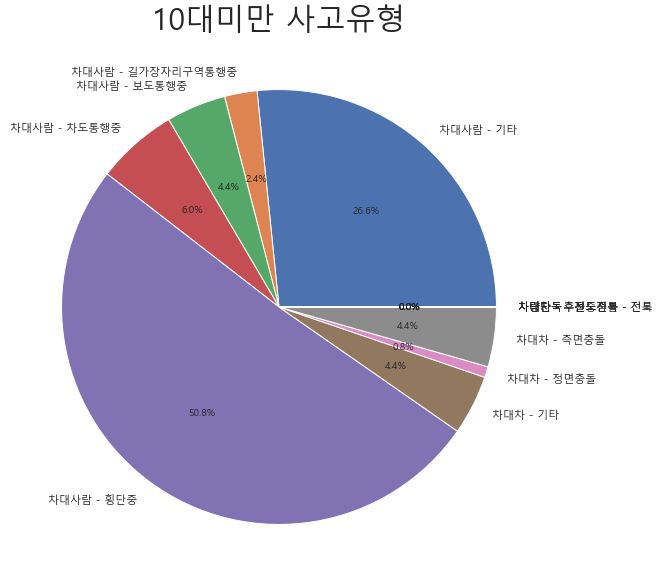

In [107]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('10대미만 사고유형',fontsize=30)
plt.pie(result_acc_type['10대미만'], labels=result_acc_type['10대미만'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a396cc240>,
 [Text(0.9675230748057451, 0.5233537042177469, '차대사람 - 기타'),
  Text(0.46703094554628416, 0.9959327767987878, '차대사람 - 길가장자리구역통행중'),
  Text(0.2442061044768837, 1.0725499422107232, '차대사람 - 보도통행중'),
  Text(0.09553342105249091, 1.0958436774750346, '차대사람 - 차도통행중'),
  Text(-0.8495847573336691, 0.6987172103979483, '차대사람 - 횡단중'),
  Text(-0.8122643448266138, -0.7417726296671994, '차대차 - 기타'),
  Text(-0.27190280745448203, -1.0658653119875752, '차대차 - 정면충돌'),
  Text(0.5535211774826144, -0.9505862959659477, '차대차 - 측면충돌'),
  Text(1.0812263660474581, -0.20235994011614133, '차대차 - 추돌'),
  Text(1.0997288959803069, -0.024420387915339757, '차대차 - 후진중충돌'),
  Text(1.0999999999999936, -1.190815315717784e-07, '차량단독 - 전도전복'),
  Text(1.0999999999999936, -1.190815315717784e-07, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999936, -1.190815315717784e-07, '차량단독 - 전도전복 - 전복')],
 [Text(0.5277398589849518, 0.2854656568460437, '15.8%'),
  Text(0.254744152116155, 0.54323606007206

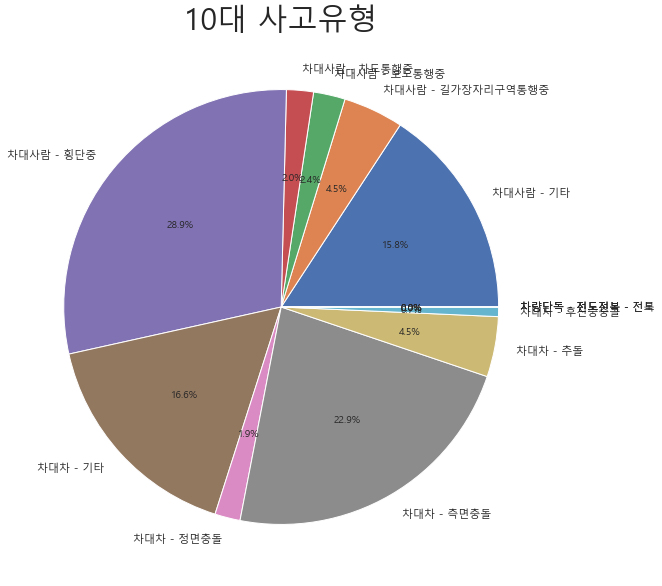

In [108]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('10대 사고유형',fontsize=30)
plt.pie(result_acc_type['10대'], labels=result_acc_type['10대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a397734a8>,
 [Text(1.0575936291909969, 0.30248258709323445, '차대사람 - 기타'),
  Text(0.875877796600762, 0.6654608068262129, '차대사람 - 길가장자리구역통행중'),
  Text(0.79334757282713, 0.7619708844104884, '차대사람 - 보도통행중'),
  Text(0.7265526236690644, 0.8259063415664025, '차대사람 - 차도통행중'),
  Text(0.4485195276677268, 1.0044054128193056, '차대사람 - 횡단중'),
  Text(-0.5596802053419611, 0.9469731082498491, '차대차 - 기타'),
  Text(-1.067932740179574, 0.2636658158589142, '차대차 - 정면충돌'),
  Text(-0.7145526261780711, -0.8363100767191689, '차대차 - 측면충돌'),
  Text(0.8360065707280954, -0.7149076959296566, '차대차 - 추돌'),
  Text(1.0964214701468584, -0.08865641432520029, '차대차 - 후진중충돌'),
  Text(1.0999999999999976, 7.40236544031502e-08, '차량단독 - 전도전복'),
  Text(1.0999999999999976, 7.40236544031502e-08, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999976, 7.40236544031502e-08, '차량단독 - 전도전복 - 전복')],
 [Text(0.5768692522859983, 0.16499050205085514, '8.9%'),
  Text(0.47775152541859744, 0.36297862190520697, '2.9%'),


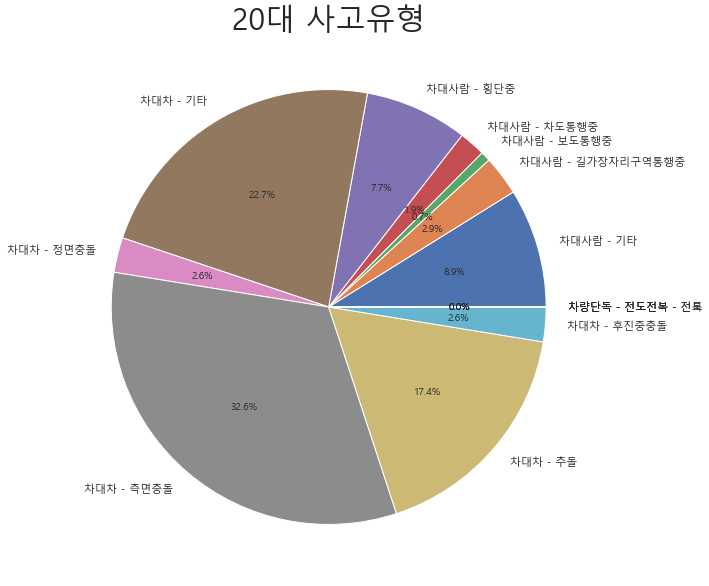

In [109]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('20대 사고유형',fontsize=30)
plt.pie(result_acc_type['20대'], labels=result_acc_type['20대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a39c8b240>,
 [Text(1.0899864268592447, 0.14808642497749908, '차대사람 - 기타'),
  Text(1.0518645597104437, 0.32183994162495544, '차대사람 - 길가장자리구역통행중'),
  Text(1.0372316742535475, 0.3662655511035446, '차대사람 - 보도통행중'),
  Text(1.0222458024845997, 0.4062185610021004, '차대사람 - 차도통행중'),
  Text(0.9378720186805102, 0.574800901683483, '차대사람 - 횡단중'),
  Text(0.052911380133805044, 1.0987267111763217, '차대차 - 기타'),
  Text(-0.8334948599097943, 0.7178344645556889, '차대차 - 정면충돌'),
  Text(-0.9630503584889649, -0.5315392807820287, '차대차 - 측면충돌'),
  Text(0.7463117671716328, -0.8080957531017934, '차대차 - 추돌'),
  Text(1.0971209852407193, -0.0795332870214315, '차대차 - 후진중충돌'),
  Text(1.0999999999999852, 1.802315072267083e-07, '차량단독 - 전도전복'),
  Text(1.0999999999999852, 1.802315072267083e-07, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999852, 1.802315072267083e-07, '차량단독 - 전도전복 - 전복')],
 [Text(0.5945380510141334, 0.0807744136240904, '4.3%'),
  Text(0.5737443052966056, 0.17554905906815751, '0.9

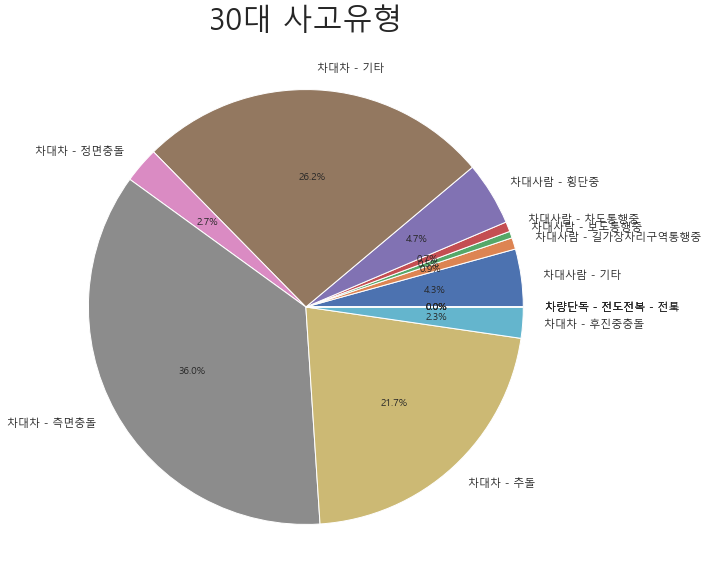

In [110]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('30대 사고유형',fontsize=30)
plt.pie(result_acc_type['30대'], labels=result_acc_type['30대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a38940080>,
 [Text(1.0879994450757073, 0.16204075880763136, '차대사람 - 기타'),
  Text(1.0446417997683235, 0.34456278118333955, '차대사람 - 길가장자리구역통행중'),
  Text(1.030995989645668, 0.38346742930078154, '차대사람 - 보도통행중'),
  Text(1.0132468229594347, 0.4281715494549029, '차대사람 - 차도통행중'),
  Text(0.9071798211293962, 0.6221131505888915, '차대사람 - 횡단중'),
  Text(-0.0030541670154928843, 1.0999957600208474, '차대차 - 기타'),
  Text(-0.8580388914872371, 0.6883089863537695, '차대차 - 정면충돌'),
  Text(-0.9694602019576203, -0.519756593820887, '차대차 - 측면충돌'),
  Text(0.7371401077603152, -0.8164707352570029, '차대차 - 추돌'),
  Text(1.0986265710179572, -0.05495140993028073, '차대차 - 후진중충돌'),
  Text(1.0999999999999945, 1.094262716853376e-07, '차량단독 - 전도전복'),
  Text(1.0999999999999945, 1.094262716853376e-07, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999945, 1.094262716853376e-07, '차량단독 - 전도전복 - 전복')],
 [Text(0.5934542427685676, 0.08838586844052618, '4.7%'),
  Text(0.5698046180554491, 0.18794333519091247, 

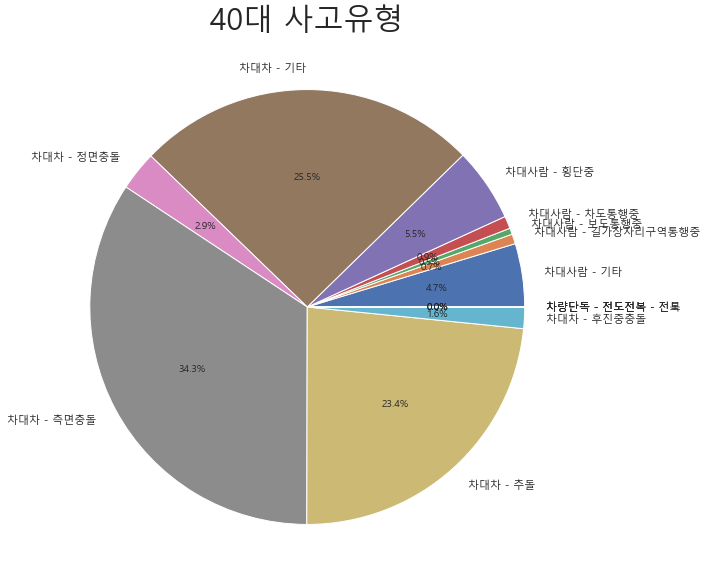

In [111]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('40대 사고유형',fontsize=30)
plt.pie(result_acc_type['40대'], labels=result_acc_type['40대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a390095c0>,
 [Text(1.0789507417481505, 0.21416184739844826, '차대사람 - 기타'),
  Text(1.0053639210795449, 0.4463668739854729, '차대사람 - 길가장자리구역통행중'),
  Text(0.9814966192973357, 0.496653185138182, '차대사람 - 보도통행중'),
  Text(0.9519134346496818, 0.5512357144937602, '차대사람 - 차도통행중'),
  Text(0.7960178832062169, 0.7591808280086463, '차대사람 - 횡단중'),
  Text(-0.19031010189658285, 1.0834122323086963, '차대차 - 기타'),
  Text(-0.9450458709281326, 0.5629283274464765, '차대차 - 정면충돌'),
  Text(-0.8938454250212959, -0.6411242907334733, '차대차 - 측면충돌'),
  Text(0.7785741517743129, -0.7770600299776776, '차대차 - 추돌'),
  Text(1.095529589507206, -0.09907027058695758, '차대차 - 후진중충돌'),
  Text(1.0992478378662693, -0.04067174629066577, '차량단독 - 전도전복'),
  Text(1.0999164185703119, -0.013559946882593175, '차량단독 - 전도전복 - 전도'),
  Text(1.0999979163486027, -0.002141034500580781, '차량단독 - 전도전복 - 전복')],
 [Text(0.588518586408082, 0.11681555312642632, '6.2%'),
  Text(0.5483803205888426, 0.24347284035571248, '0.8%'

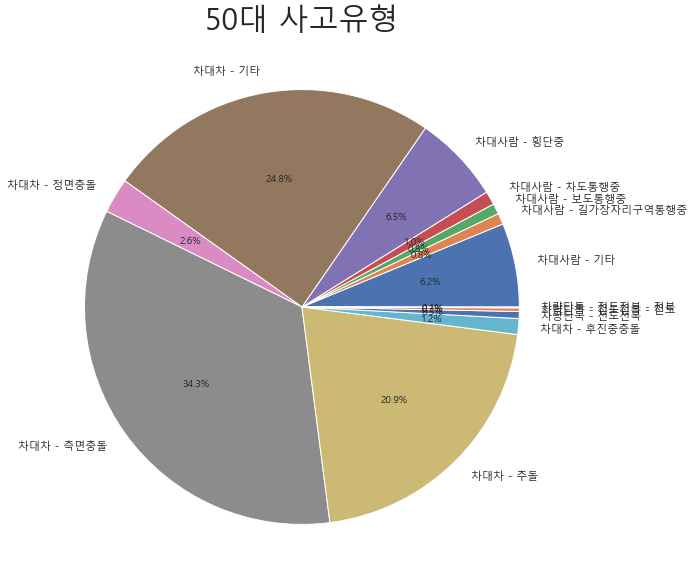

In [112]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('50대 사고유형',fontsize=30)
plt.pie(result_acc_type['50대'], labels=result_acc_type['50대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a38c66438>,
 [Text(1.062566698062481, 0.2845206708986119, '차대사람 - 기타'),
  Text(0.9373478932881074, 0.5756552153401783, '차대사람 - 길가장자리구역통행중'),
  Text(0.9055757478074222, 0.6244458062818807, '차대사람 - 보도통행중'),
  Text(0.8650777668653189, 0.6794412831697181, '차대사람 - 차도통행중'),
  Text(0.5593478406925981, 0.9471694637774848, '차대사람 - 횡단중'),
  Text(-0.5034760280936319, 0.9780142581450745, '차대차 - 기타'),
  Text(-1.0410669381359647, 0.35521772241852967, '차대차 - 정면충돌'),
  Text(-0.7434473026540254, -0.810731834934619, '차대차 - 측면충돌'),
  Text(0.879404299517625, -0.6607935214497155, '차대차 - 추돌'),
  Text(1.0997720104368476, -0.022394755182732443, '차대차 - 후진중충돌'),
  Text(1.0999999999999999, 1.609209831757271e-08, '차량단독 - 전도전복'),
  Text(1.0999999999999999, 1.609209831757271e-08, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999999, 1.609209831757271e-08, '차량단독 - 전도전복 - 전복')],
 [Text(0.5795818353068078, 0.15519309321742467, '8.3%'),
  Text(0.5112806690662404, 0.31399375382191536, '0.9%

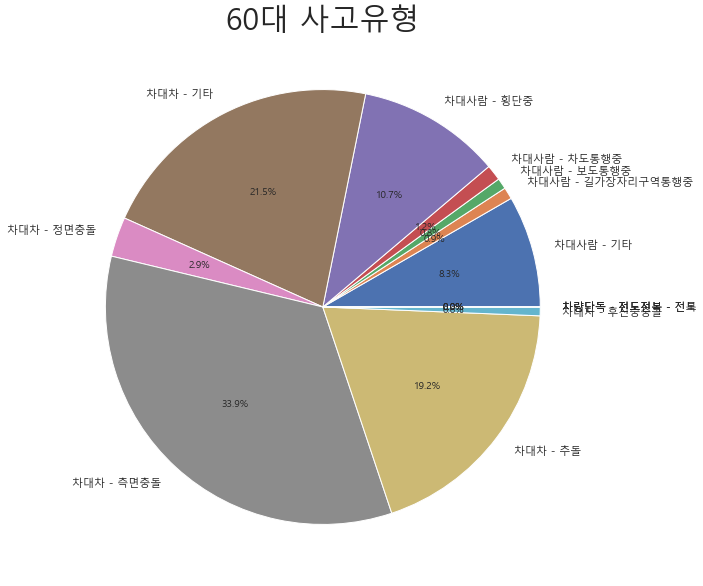

In [113]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('60대 사고유형',fontsize=30)
plt.pie(result_acc_type['60대'], labels=result_acc_type['60대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a399c2588>,
 [Text(0.9907090801026053, 0.47801204859527324, '차대사람 - 기타'),
  Text(0.6197652014889351, 0.9087855055090722, '차대사람 - 길가장자리구역통행중'),
  Text(0.5190117903702959, 0.9698591451631624, '차대사람 - 보도통행중'),
  Text(0.3611740756614014, 1.039015537453667, '차대사람 - 차도통행중'),
  Text(-0.5139349106486494, 0.9725589481448232, '차대사람 - 횡단중'),
  Text(-1.0948605386671044, -0.10620923156476583, '차대차 - 기타'),
  Text(-0.8939569517776873, -0.6409687733176601, '차대차 - 정면충돌'),
  Text(-1.029894329174279e-07, -1.0999999999999954, '차대차 - 측면충돌'),
  Text(1.0371133772917653, -0.3666003854914349, '차대차 - 추돌'),
  Text(1.0999661854097196, -0.008625019141451574, '차대차 - 후진중충돌'),
  Text(1.0999999999999954, -1.0298943298478347e-07, '차량단독 - 전도전복'),
  Text(1.0999999999999954, -1.0298943298478347e-07, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999954, -1.0298943298478347e-07, '차량단독 - 전도전복 - 전복')],
 [Text(0.5403867709650574, 0.26073384468833083, '14.3%'),
  Text(0.3380537462666919, 0.49570118

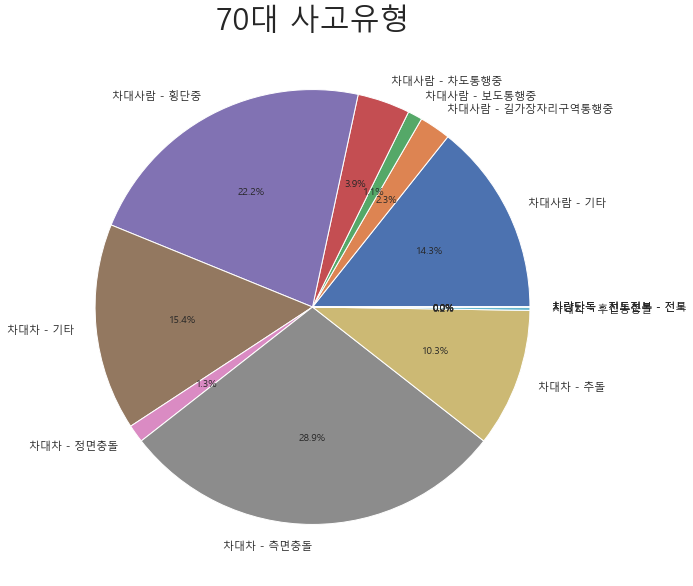

In [114]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('70대 사고유형',fontsize=30)
plt.pie(result_acc_type['70대'], labels=result_acc_type['70대'].index, autopct='%0.1f%%')

([<matplotlib.patches.Wedge at 0x7f6a38e708d0>,
 [Text(0.6412774143953438, 0.8937355748690005, '차대사람 - 기타'),
  Text(-0.4533590244538494, 1.0022303103310408, '차대사람 - 길가장자리구역통행중'),
  Text(-0.6500754344475528, 0.8873567092932954, '차대사람 - 보도통행중'),
  Text(-0.8609817299964334, 0.6846243207864797, '차대사람 - 차도통행중'),
  Text(-1.0385277680722533, -0.36257423369961655, '차대사람 - 횡단중'),
  Text(-0.021732857824589, -1.099785289450071, '차대차 - 기타'),
  Text(0.39319002957376975, -1.0273274067422606, '차대차 - 정면충돌'),
  Text(0.7816500898523053, -0.7739658500437103, '차대차 - 측면충돌'),
  Text(1.0741212586060347, -0.23719932927938084, '차대차 - 추돌'),
  Text(1.0995169210990023, -0.03259662892033812, '차대차 - 후진중충돌'),
  Text(1.0999999999999996, 3.218419788156398e-08, '차량단독 - 전도전복'),
  Text(1.0999999999999996, 3.218419788156398e-08, '차량단독 - 전도전복 - 전도'),
  Text(1.0999999999999996, 3.218419788156398e-08, '차량단독 - 전도전복 - 전복')],
 [Text(0.3497876805792784, 0.48749213174672745, '30.2%'),
  Text(-0.24728674061119055, 0.54667107836238

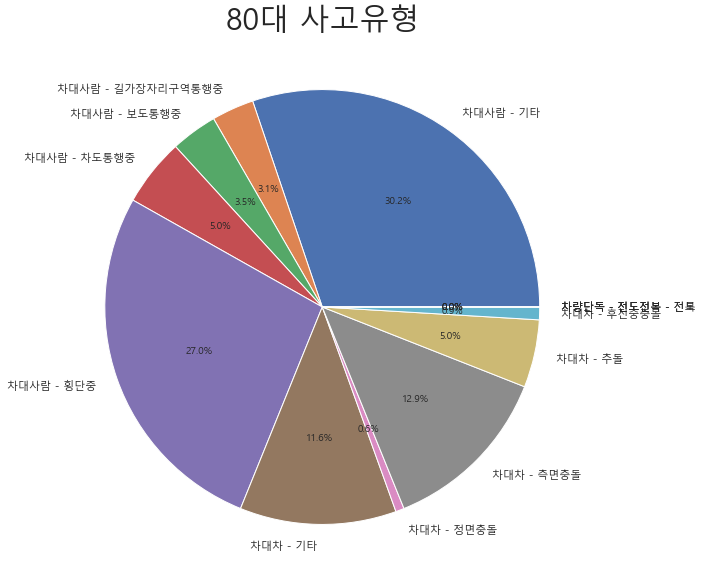

In [115]:
plt.rcParams['figure.figsize']=(10,10)
plt.title('80대 사고유형',fontsize=30)
plt.pie(result_acc_type['80대'], labels=result_acc_type['80대'].index, autopct='%0.1f%%')

#### 연령대별 큰사고유형 (차대차,차대사람,차량단독) 파악

In [128]:
under_10_year_acc_bigtype=df_under_10_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_10_acc_bigtype=df_10_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_20_acc_bigtype=df_20_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_30_acc_bigtype=df_30_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_40_acc_bigtype=df_40_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_50_acc_bigtype=df_50_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_60_acc_bigtype=df_60_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_70_acc_bigtype=df_70_year.groupby(['큰사고유형'])[['큰사고유형']].count()
year_80_acc_bigtype=df_80_year.groupby(['큰사고유형'])[['큰사고유형']].count()

result_acc_bigtype=pd.concat([under_10_year_acc_bigtype,year_10_acc_bigtype,year_20_acc_bigtype,year_30_acc_bigtype,year_40_acc_bigtype,year_50_acc_bigtype,year_60_acc_bigtype,year_70_acc_bigtype,year_80_acc_bigtype], axis=1,ignore_index=True)
result_acc_bigtype.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)
result_acc_bigtype=result_acc_bigtype.fillna(0).astype(int)
result_acc_bigtype

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대
차대사람,224,454,819,468,557,745,674,527,219
차대차,24,395,2880,3743,3969,4056,2412,675,99
차량단독,0,0,0,0,0,41,0,0,0


<AxesSubplot:>

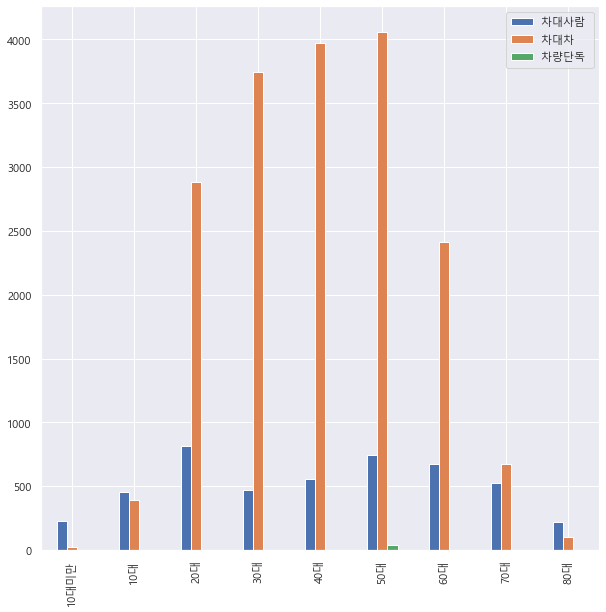

In [129]:
result_acc_bigtype.transpose().plot.bar()

#### 연령대별 피해자유형 파악

In [208]:
under_10_year_acc_type=df_under_10_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_10_acc_type=df_10_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_20_acc_type=df_20_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_30_acc_type=df_30_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_40_acc_type=df_40_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_50_acc_type=df_50_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_60_acc_type=df_60_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_70_acc_type=df_70_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()
year_80_acc_type=df_80_year.groupby(['피해운전자 차종'])[['피해운전자 차종']].count()


In [209]:
pihae_person_type = pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)
pihae_person_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)
pihae_person_type=pihae_person_type.fillna(0).astype(int)

pihae_person_type['합계']=pihae_person_type['10대미만'] + pihae_person_type['10대'] + pihae_person_type['20대']
+ pihae_person_type['30대'] + pihae_person_type['40대'] +pihae_person_type['50대'] +pihae_person_type['60대'] 
+pihae_person_type['70대'] +pihae_person_type['80대'] 

pihae_person_type.sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
승용,1,63,1987,2930,2905,2866,1778,363,28,2051
보행자,224,454,819,468,557,745,674,527,219,1497
이륜,0,113,520,392,312,213,105,59,13,633
자전거,21,178,133,63,107,197,199,168,44,332
원동기,0,35,109,74,89,66,38,20,6,144
화물,0,1,71,161,253,330,172,40,3,72
개인형이동수단(PM),1,3,20,14,17,10,2,3,2,24
승합,0,1,21,84,258,328,106,17,0,22
특수,0,0,12,24,16,8,1,0,0,12
사륜오토바이(ATV),0,1,4,0,3,2,0,0,1,5


#### 피해자 연령대별 가해자 차종유형 파악

In [205]:
under_10_year_acc_type=df_under_10_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_10_acc_type=df_10_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_20_acc_type=df_20_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_30_acc_type=df_30_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_40_acc_type=df_40_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_50_acc_type=df_50_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_60_acc_type=df_60_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_70_acc_type=df_70_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()
year_80_acc_type=df_80_year.groupby(['가해운전자 차종'])[['가해운전자 차종']].count()


In [206]:
gahae_person_type = pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)
gahae_person_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)

gahae_person_type=gahae_person_type.fillna(0).astype(int)
gahae_person_type['합계']=gahae_person_type['10대미만'] + gahae_person_type['10대'] + gahae_person_type['20대']
+ gahae_person_type['30대'] + gahae_person_type['40대'] +gahae_person_type['50대'] +gahae_person_type['60대'] 
+gahae_person_type['70대'] +gahae_person_type['80대'] 

gahae_person_type.sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
승용,182,618,2922,3331,3475,3609,2258,828,218,3722
화물,21,62,289,381,428,540,341,180,57,372
이륜,13,57,156,151,173,197,124,31,3,226
승합,14,41,144,151,181,217,177,81,25,199
기타불명,6,53,83,54,65,78,52,22,7,142
자전거,7,5,34,51,88,85,62,30,3,46
원동기,1,11,33,40,47,45,19,16,2,45
건설기계,0,1,17,31,37,35,28,10,1,18
특수,0,0,15,13,24,21,16,3,2,15
개인형이동수단(PM),4,0,6,8,8,13,6,0,0,10


#### 피해자 연령대별 가해자 법규유형 파악

In [203]:
under_10_year_acc_type=df_under_10_year.groupby(['법규위반'])[['법규위반']].count()
year_10_acc_type=df_10_year.groupby(['법규위반'])[['법규위반']].count()
year_20_acc_type=df_20_year.groupby(['법규위반'])[['법규위반']].count()
year_30_acc_type=df_30_year.groupby(['법규위반'])[['법규위반']].count()
year_40_acc_type=df_40_year.groupby(['법규위반'])[['법규위반']].count()
year_50_acc_type=df_50_year.groupby(['법규위반'])[['법규위반']].count()
year_60_acc_type=df_60_year.groupby(['법규위반'])[['법규위반']].count()
year_70_acc_type=df_70_year.groupby(['법규위반'])[['법규위반']].count()
year_80_acc_type=df_80_year.groupby(['법규위반'])[['법규위반']].count()

In [204]:
illegal_type = pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)
illegal_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)

illegal_type=illegal_type.fillna(0).astype(int)

illegal_type['합계']=illegal_type['10대미만'] + illegal_type['10대'] + illegal_type['20대']
+ illegal_type['30대'] + illegal_type['40대'] +illegal_type['50대'] +illegal_type['60대'] 
+illegal_type['70대'] +illegal_type['80대'] 

illegal_type.sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
안전운전불이행,150,514,2126,2379,2498,2666,1663,709,209,2790
신호위반,29,126,522,580,693,754,532,156,31,677
안전거리미확보,3,32,393,492,545,562,303,74,4,428
교차로운행방법위반,2,26,247,356,330,342,212,76,11,275
보행자보호의무위반,47,97,121,87,120,143,147,102,35,265
중앙선침범,1,18,135,156,151,169,91,23,4,154
기타,15,22,55,46,54,65,57,33,15,92
직진우회전진행방해,1,6,47,43,54,64,30,8,6,54
불법유턴,0,3,23,23,28,25,11,8,0,26
차로위반,0,2,22,35,43,38,28,5,1,24


#### 피해자 연령대별 시군구 위치유형 확인

##### 1. 구까지 표기

In [201]:
under_10_year_acc_type=df_under_10_year.groupby(['구'])[['구']].count()
year_10_acc_type=df_10_year.groupby(['구'])[['구']].count()
year_20_acc_type=df_20_year.groupby(['구'])[['구']].count()
year_30_acc_type=df_30_year.groupby(['구'])[['구']].count()
year_40_acc_type=df_40_year.groupby(['구'])[['구']].count()
year_50_acc_type=df_50_year.groupby(['구'])[['구']].count()
year_60_acc_type=df_60_year.groupby(['구'])[['구']].count()
year_70_acc_type=df_70_year.groupby(['구'])[['구']].count()
year_80_acc_type=df_80_year.groupby(['구'])[['구']].count()


spot_gu_type = pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)

spot_gu_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)

spot_gu_type=spot_gu_type.fillna(0).astype(int)



spot_gu_type['합계']=spot_gu_type['10대미만'] + spot_gu_type['10대'] + spot_gu_type['20대'] + spot_gu_type['30대'] + spot_gu_type['40대'] +spot_gu_type['50대'] +spot_gu_type['60대'] +spot_gu_type['70대'] +spot_gu_type['80대'] 

spot_gu_type.sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
구,,,,,,,,,,
서구,95,311,1371,1448,1339,1429,879,280,77,7229
유성구,55,187,922,1199,1197,1224,650,214,46,5694
동구,23,138,553,564,669,766,595,272,66,3646
중구,47,128,488,523,699,747,571,276,81,3560
대덕구,28,85,365,477,622,676,391,160,48,2852


##### 2. 동까지  표기

In [171]:
under_10_year_acc_type=df_under_10_year.groupby(['구','동'])[['동']].count()
year_10_acc_type=df_10_year.groupby(['구','동'])[['동']].count()
year_20_acc_type=df_20_year.groupby(['구','동'])[['동']].count()
year_30_acc_type=df_30_year.groupby(['구','동'])[['동']].count()
year_40_acc_type=df_40_year.groupby(['구','동'])[['동']].count()
year_50_acc_type=df_50_year.groupby(['구','동'])[['동']].count()
year_60_acc_type=df_60_year.groupby(['구','동'])[['동']].count()
year_70_acc_type=df_70_year.groupby(['구','동'])[['동']].count()
year_80_acc_type=df_80_year.groupby(['구','동'])[['동']].count()

In [175]:
pd.set_option('display.max_row', 159)
spot_type = pd.concat([under_10_year_acc_type,year_10_acc_type,year_20_acc_type,year_30_acc_type,year_40_acc_type,year_50_acc_type,year_60_acc_type,year_70_acc_type,year_80_acc_type], axis=1,ignore_index=True)

spot_type.rename(columns = {0: "10대미만", 1: "10대",2: "20대",3: "30대",4: "40대",5: "50대"
                                 ,6: "60대",7: "70대",8: "80대"}, inplace=True)

spot_type=spot_type.fillna(0).astype(int)


spot_type['합계']=spot_type['10대미만'] + spot_type['10대'] + spot_type['20대'] + spot_type['30대'] + spot_type['40대'] +spot_type['50대'] +spot_type['60대'] +spot_type['70대'] +spot_type['80대'] 

spot_type

10대미만  10대  20대  30대  40대  50대  60대  70대  80대    합계
구   동                                                        
대덕구 갈전동       0    0    0    0    0    0    1    0    0     1
    대화동       4    2   12   25   35   25   13    4    4   124
    덕암동       1    4   17   19   25   22    9    8    2   107
    목상동       3    4   16   20   16   17   11    4    1    92
    문평동       0    0    8   11   15   14    7    4    0    59
    미호동       0    1    0    1    5    3    1    0    0    11
    법동        3    9   11   25   41   46   23   14    9   181
    비래동       3    7   26   26   38   55   28   10    3   196
    삼정동       0    0    0    0    1    2    1    1    0     5
    상서동       0    1   18   14   29   29   14    2    0   107
    석봉동       1    6   12   13   17   26   16    5    3    99
    송촌동       6   15   29   39   43   50   31   10    6   229
    신대동       0    0    7   27   27   25   13    3    1   103
    신일동       0    1   13   11   23   23   12    1    1    85
    신탄진동      2    1   39   20   35   49   20   13    7   186
    연축동       0    0    0    0    5    6    3    0    0    14
    오정동       1   12   72  102  120  128   94   33    3   565
    와동        1    0    7    9    9   10    3    3    1    43
    용호동       0    0    0    1    1    2    2    0    0     6
    읍내동       0    3   21   33   29   34   25   15    1   161
    이현동       0    0    0    1    0    1    0    0    1     3
    장동        0    0    0    1    0    0    0    0    0     1
    중리동       3   18   53   72  100  100   60   26    3   435
    평촌동       0    1    4    7    8    9    4    4    2    39
동구  가양동       7   23   81   86   75  114   81   37   10   514
    가오동       2   10   27   38   39   32   17   10    2   177
    구도동       0    1    3    5    9    9    0    2    0    29
    낭월동       1    1    8    7   10   17   10    1    2    57
    대동        0   15   29   25   40   28   32   13    3   185
    대별동       0    0    2    3    4    5    3    1    0    18
    대성동       1    7   14   20   17   12    9    4    2    86
    마산동       0    0    0    1    0    1    0    0    0     2
    비룡동       0    0    1    2    7    6    3    0    0    19
    사성동       0    0    1    0    0    0    0    0    0     1
    삼괴동       0    0    4    2    3    5    2    2    0    18
    삼성동       1   10   40   44   67   70   60   31    8   331
    삼정동       0    0    2    3    4    2    4    3    0    18
    상소동       0    1    1    0    2    6    0    1    0    11
    성남동       2    4   21   29   45   54   31   16    3   205
    세천동       0    0    4    2    3    3    3    3    0    18
    소제동       1    1    6   14   12   14   20    6    1    75
    신상동       0    0    2    3    6    3    5    3    1    23
    신안동       0    0    1    1    3    4    6    3    0    18
    신하동       0    0    0    0    0    1    1    0    0     2
    신흥동       0    2    8   14   17   19   19    7    2    88
    용운동       1    4   37   16   27   16   28   13    4   146
    용전동       1   14   92   84   77  110   73   28    2   481
    원동        0    3    9   16   17   31   28    8    5   117
    이사동       0    0    0    0    1    0    0    0    0     1
    인동        0    3   11   23   26   33   22   17    2   137
    자양동       1   17   51   23   23   24   16    5    1   161
    정동        0    2    7   12   20   19   27    8    2    97
    주산동       0    0    3    1    2    2    2    0    0    10
    주촌동       1    1    0    0    0    0    0    0    0     2
    중동        0    3   14   17   22   30   25   11    5   127
    천동        1    3   15    7   10   14   10    1    1    62
    추동        1    1    1    0    1    4    1    0    0     9
    판암동       2    5   21   29   32   38   36   24    4   191
    하소동       0    0    0    2    2    0    1    0    0     5
    홍도동       0    6   30   31   35   31   11    8    4   156
    효동        0    1    7    4   11    8    9    5    2    47
    효평동       0    0    0    0    0    1    0    1    0     2
서구  가수원동      3    6   26   42   42   36  

#### 각 구별로  연령별 사고건수 파악
##### 1. 대덕구

In [196]:
spot_type.xs("대덕구").sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
동,,,,,,,,,,
오정동,1,12,72,102,120,128,94,33,3,565
중리동,3,18,53,72,100,100,60,26,3,435
송촌동,6,15,29,39,43,50,31,10,6,229
비래동,3,7,26,26,38,55,28,10,3,196
신탄진동,2,1,39,20,35,49,20,13,7,186
법동,3,9,11,25,41,46,23,14,9,181
읍내동,0,3,21,33,29,34,25,15,1,161
대화동,4,2,12,25,35,25,13,4,4,124
덕암동,1,4,17,19,25,22,9,8,2,107


##### 동구

In [197]:
spot_type.xs("동구").sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
동,,,,,,,,,,
가양동,7,23,81,86,75,114,81,37,10,514
용전동,1,14,92,84,77,110,73,28,2,481
삼성동,1,10,40,44,67,70,60,31,8,331
성남동,2,4,21,29,45,54,31,16,3,205
판암동,2,5,21,29,32,38,36,24,4,191
대동,0,15,29,25,40,28,32,13,3,185
가오동,2,10,27,38,39,32,17,10,2,177
자양동,1,17,51,23,23,24,16,5,1,161
홍도동,0,6,30,31,35,31,11,8,4,156


##### 3. 서구

In [198]:
spot_type.xs("서구").sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
동,,,,,,,,,,
둔산동,8,99,429,372,364,381,177,53,15,1898
갈마동,14,47,220,185,155,169,119,30,5,944
월평동,8,23,137,178,164,188,131,34,5,868
탄방동,8,25,135,158,134,130,69,29,7,695
도마동,6,20,59,81,65,86,68,30,11,426
관저동,10,24,61,69,67,68,55,13,5,372
괴정동,10,11,68,71,60,57,32,17,3,329
용문동,2,6,57,56,59,72,43,9,1,305
만년동,1,10,32,47,48,47,27,4,2,218


##### 4. 유성구

In [199]:
spot_type.xs("유성구").sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
동,,,,,,,,,,
봉명동,5,31,195,211,189,236,124,38,11,1040
장대동,0,9,76,103,107,99,57,27,8,486
구암동,3,9,55,82,84,92,51,26,4,406
노은동,2,10,39,63,73,66,53,14,1,321
궁동,0,12,98,53,49,50,28,2,0,292
관평동,1,18,46,61,68,53,24,4,3,278
원내동,5,12,22,54,52,58,30,21,1,255
지족동,7,18,41,42,62,52,21,10,2,255
반석동,2,10,26,44,41,33,16,7,1,180


##### 5. 중구

In [200]:
spot_type.xs("중구").sort_values(by=["합계"], ascending=False)

,10대미만,10대,20대,30대,40대,50대,60대,70대,80대,합계
동,,,,,,,,,,
대흥동,2,16,63,65,79,104,52,27,8,416
선화동,3,12,45,54,76,73,47,19,7,336
유천동,9,19,32,44,66,68,56,31,8,333
문화동,10,14,48,57,63,60,43,24,8,327
태평동,5,13,42,49,60,63,52,24,7,315
오류동,0,6,49,58,60,52,55,15,5,300
산성동,3,8,26,28,45,47,42,23,10,232
중촌동,4,7,30,31,44,39,24,19,1,199
용두동,0,6,30,32,33,46,40,10,1,198


## subplot

In [ ]:
plt.rcParams['figure.figsize']=(50,50)

fig, ax = plt.subplots(9, 1)

# 각 액자들에 그래프를 그린다.
# ax[0].title('10대미만 사고유형',fontsize=30)
ax[0][0].pie(result_acc_type['10대미만'], labels=result_acc_type['10대미만'].index, autopct='%0.1f%%')

# ax[1].title('10대 사고유형',fontsize=30)
ax[1][0].pie(result_acc_type['10대'], labels=result_acc_type['10대'].index, autopct='%0.1f%%')

# ax[2].title('20대 사고유형',fontsize=30)
ax[2][0].pie(result_acc_type['20대'], labels=result_acc_type['20대'].index, autopct='%0.1f%%')

# ax[3].title('30대 사고유형',fontsize=30)
ax[3][0].pie(result_acc_type['30대'], labels=result_acc_type['30대'].index, autopct='%0.1f%%')

# ax[4].title('40대 사고유형',fontsize=30)
ax[4][0].pie(result_acc_type['40대'], labels=result_acc_type['40대'].index, autopct='%0.1f%%')

# ax[5].title('50대 사고유형',fontsize=30)
ax[5][0].pie(result_acc_type['50대'], labels=result_acc_type['50대'].index, autopct='%0.1f%%')

# ax[6].title('60대 사고유형',fontsize=30)
ax[6][0].pie(result_acc_type['60대'], labels=result_acc_type['60대'].index, autopct='%0.1f%%')

# ax[7].title('70대 사고유형',fontsize=30)
ax[7][0].pie(result_acc_type['70대'], labels=result_acc_type['70대'].index, autopct='%0.1f%%')

# ax[2][2].title('80대 사고유형')
ax[8][0].pie(result_acc_type['80대'], labels=result_acc_type['80대'].index, autopct='%0.1f%%')
plt.show()